In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms, models
from PIL import Image
from torch.utils.data import Dataset, DataLoader

In [2]:
print("CUDA Available: ", torch.cuda.is_available())
print("Number of GPUs: ", torch.cuda.device_count())
print("Current GPU: ", torch.cuda.current_device())
print("GPU Name: ", torch.cuda.get_device_name(0))

CUDA Available:  True
Number of GPUs:  1
Current GPU:  0
GPU Name:  NVIDIA GeForce RTX 2080


In [3]:
# Define the Basic Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, kernel_size=3, skip_kernel_size=1):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=kernel_size//2, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Skip connection
        self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=skip_kernel_size, stride=stride, padding=skip_kernel_size//2, bias=False) \
            if in_channels != out_channels or stride != 1 else nn.Identity()
        
    def forward(self, x):
        residual = self.skip(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return F.relu(x)

In [4]:
# Define the Custom ResNet-18 Architecture
class CustomResNet18(nn.Module):
    def __init__(self, num_classes=10, block=ResidualBlock, layers=[2, 2, 2, 2], channels=[48, 96, 192, 320], kernel_size=3, skip_kernel_size=1, pool_size=4):
        super(CustomResNet18, self).__init__()
        
        self.in_channels = channels[0]
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        
        # Residual Layers
        self.layer1 = self.make_layer(block, channels[0], layers[0], stride=1, kernel_size=kernel_size, skip_kernel_size=skip_kernel_size)
        self.layer2 = self.make_layer(block, channels[1], layers[1], stride=2, kernel_size=kernel_size, skip_kernel_size=skip_kernel_size)
        self.layer3 = self.make_layer(block, channels[2], layers[2], stride=2, kernel_size=kernel_size, skip_kernel_size=skip_kernel_size)
        self.layer4 = self.make_layer(block, channels[3], layers[3], stride=2, kernel_size=kernel_size, skip_kernel_size=skip_kernel_size)
        
        # Average Pool and Fully Connected Layer
        self.avg_pool = nn.AvgPool2d(kernel_size=pool_size)
        self.fc = nn.Linear(channels[3], num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride, kernel_size, skip_kernel_size):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride, kernel_size, skip_kernel_size))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [5]:
import os
import pickle
import numpy as np

def unpickle(file):
    with open(file, 'rb') as fo:
        dict_data = pickle.load(fo, encoding='bytes')
    return dict_data

def load_cifar10_data(data_dir):
    """
    Loads CIFAR-10 training and test data from local files.
    
    Args:
        data_dir (str): Directory where CIFAR-10 files are stored.
        
    Returns:
        train_images (np.ndarray): Shape (50000, 3, 32, 32)
        train_labels (np.ndarray): Shape (50000,)
        test_images (np.ndarray): Shape (10000, 3, 32, 32)
        test_labels (np.ndarray): Shape (10000,)
    """
    # Load training batches
    train_images_list = []
    train_labels_list = []
    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f"data_batch_{i}")
        batch_data = unpickle(batch_file)
        train_images_list.append(batch_data[b"data"])
        train_labels_list.extend(batch_data[b"labels"])
    train_images = np.concatenate(train_images_list, axis=0)
    train_images = train_images.reshape(-1, 3, 32, 32)
    train_labels = np.array(train_labels_list)
    
    # Load test batch
    test_file = os.path.join(data_dir, "test_batch")
    test_data = unpickle(test_file)
    test_images = test_data[b"data"].reshape(-1, 3, 32, 32)
    test_labels = np.array(test_data[b"labels"])
    
    return train_images, train_labels, test_images, test_labels


In [6]:
import torch
from torch.utils.data import Dataset

class CIFAR10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get image and label
        img = self.images[idx]
        label = self.labels[idx]
        
        # Convert image from (3, 32, 32) to (32, 32, 3) for PIL Image compatibility
        img = np.transpose(img, (1, 2, 0))
        
        # Apply transforms if provided
        if self.transform:
            img = self.transform(img)
        
        # Convert label to a torch tensor of type long
        label = torch.tensor(label, dtype=torch.long)
        
        return img, label


In [15]:
# Hyperparameters
learning_rate = 0.001
batch_size = 256

In [16]:
from torch.utils.data import DataLoader
from torchvision import transforms

# Define your transformation (example using CIFAR-10 normalization and augmentation)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
trian_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # Randomly crop & resize
    transforms.RandomHorizontalFlip(),  # Flip with 50% probability
    transforms.RandomRotation(15),  # Rotate within ±15 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random shift
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Random perspective transformation
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),  # Erase random patches
 
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# Path to your local CIFAR-10 batch files
DATA_DIR = "./"  # Adjust if needed

# Load the data from local files
train_images, train_labels, test_images, test_labels = load_cifar10_data(DATA_DIR)

# Create the dataset objects using the custom Dataset class
# Apply augmentations only to training data
train_dataset = CIFAR10Dataset(train_images, train_labels, transform=trian_transform)
test_dataset = CIFAR10Dataset(test_images, test_labels, transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
]))


# Create DataLoaders

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [17]:
# Model, Loss, Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_per_process_memory_fraction(0.5, device=0)

In [18]:
model = CustomResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
print("Using device:", device)
# Model Summary
summary(model, (3, 32, 32))

Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 32, 32]           1,296
       BatchNorm2d-2           [-1, 48, 32, 32]              96
          Identity-3           [-1, 48, 32, 32]               0
            Conv2d-4           [-1, 48, 32, 32]          20,736
       BatchNorm2d-5           [-1, 48, 32, 32]              96
            Conv2d-6           [-1, 48, 32, 32]          20,736
       BatchNorm2d-7           [-1, 48, 32, 32]              96
     ResidualBlock-8           [-1, 48, 32, 32]               0
          Identity-9           [-1, 48, 32, 32]               0
           Conv2d-10           [-1, 48, 32, 32]          20,736
      BatchNorm2d-11           [-1, 48, 32, 32]              96
           Conv2d-12           [-1, 48, 32, 32]          20,736
      BatchNorm2d-13           [-1, 48, 32, 32]              96
    ResidualBlock-14

In [19]:

# Training Loop
# Training Loop with Progress Bar
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Use tqdm for progress bar
    progress_bar = tqdm(loader, desc="Training")
    


    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Update the progress bar with the latest metrics
        progress_bar.set_postfix(loss=loss.item(), accuracy=100. * correct / total)
    
    train_loss = running_loss / len(loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc


In [20]:

# Evaluation Loop with Progress Bar
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Use tqdm for progress bar
    progress_bar = tqdm(loader, desc="Eval")

    with torch.no_grad():
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Update the progress bar with the latest metrics
            progress_bar.set_postfix(loss=loss.item(), accuracy=100. * correct / total)
    
    test_loss = running_loss / len(loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc


In [21]:
model_path = "Project1_model.pth"
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cuda")))
    model.to(device)
    model.eval()
    print(f"Model loaded from '{model_path,device}'.")

Model loaded from '('Project1_model.pth', device(type='cuda'))'.


In [56]:
# Training and Evaluation
epochs = 1000
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    scheduler.step()
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")                                                                              

    # Save the Model
    torch.save(model.state_dict(), 'Project1_model.pth')


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.32it/s, accuracy=94.3, loss=0.0595]


Epoch [1/1000] | Train Loss: 0.1904, Train Acc: 93.30% | Test Loss: 0.1723, Test Acc: 94.27%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.44it/s, accuracy=94.2, loss=0.0631]


Epoch [2/1000] | Train Loss: 0.1878, Train Acc: 93.51% | Test Loss: 0.1727, Test Acc: 94.17%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.64it/s, accuracy=94.2, loss=0.0524]


Epoch [3/1000] | Train Loss: 0.1895, Train Acc: 93.50% | Test Loss: 0.1723, Test Acc: 94.21%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.54it/s, accuracy=94.2, loss=0.0504]


Epoch [4/1000] | Train Loss: 0.1880, Train Acc: 93.65% | Test Loss: 0.1720, Test Acc: 94.25%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.74it/s, accuracy=94.2, loss=0.053]


Epoch [5/1000] | Train Loss: 0.1834, Train Acc: 93.74% | Test Loss: 0.1723, Test Acc: 94.23%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.19it/s, accuracy=94.4, loss=0.0696]


Epoch [6/1000] | Train Loss: 0.1866, Train Acc: 93.55% | Test Loss: 0.1708, Test Acc: 94.37%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.46it/s, accuracy=94.3, loss=0.0787]


Epoch [7/1000] | Train Loss: 0.1851, Train Acc: 93.68% | Test Loss: 0.1727, Test Acc: 94.29%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.20it/s, accuracy=94.3, loss=0.0606]


Epoch [8/1000] | Train Loss: 0.1861, Train Acc: 93.58% | Test Loss: 0.1700, Test Acc: 94.29%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.11it/s, accuracy=94.3, loss=0.0607]


Epoch [9/1000] | Train Loss: 0.1818, Train Acc: 93.81% | Test Loss: 0.1714, Test Acc: 94.32%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.47it/s, accuracy=94.3, loss=0.0616]


Epoch [10/1000] | Train Loss: 0.1840, Train Acc: 93.60% | Test Loss: 0.1703, Test Acc: 94.29%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.85it/s, accuracy=94.1, loss=0.0542]


Epoch [11/1000] | Train Loss: 0.1815, Train Acc: 93.72% | Test Loss: 0.1724, Test Acc: 94.14%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.60it/s, accuracy=94.4, loss=0.0601]


Epoch [12/1000] | Train Loss: 0.1779, Train Acc: 93.85% | Test Loss: 0.1700, Test Acc: 94.36%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.98it/s, accuracy=94.3, loss=0.0589]


Epoch [13/1000] | Train Loss: 0.1801, Train Acc: 93.80% | Test Loss: 0.1704, Test Acc: 94.35%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.33it/s, accuracy=94.4, loss=0.0622]


Epoch [14/1000] | Train Loss: 0.1810, Train Acc: 93.84% | Test Loss: 0.1717, Test Acc: 94.36%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.40it/s, accuracy=94.4, loss=0.0385]


Epoch [15/1000] | Train Loss: 0.1804, Train Acc: 93.72% | Test Loss: 0.1694, Test Acc: 94.36%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.46it/s, accuracy=94.3, loss=0.046]


Epoch [16/1000] | Train Loss: 0.1734, Train Acc: 94.01% | Test Loss: 0.1702, Test Acc: 94.31%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.48it/s, accuracy=94.4, loss=0.0569]


Epoch [17/1000] | Train Loss: 0.1762, Train Acc: 93.96% | Test Loss: 0.1700, Test Acc: 94.36%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.58it/s, accuracy=94.3, loss=0.0489]


Epoch [18/1000] | Train Loss: 0.1821, Train Acc: 93.58% | Test Loss: 0.1704, Test Acc: 94.34%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.43it/s, accuracy=94.5, loss=0.0464]


Epoch [19/1000] | Train Loss: 0.1773, Train Acc: 93.85% | Test Loss: 0.1689, Test Acc: 94.49%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.20it/s, accuracy=94.5, loss=0.0503]


Epoch [20/1000] | Train Loss: 0.1772, Train Acc: 93.86% | Test Loss: 0.1679, Test Acc: 94.45%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.24it/s, accuracy=94.5, loss=0.0527]


Epoch [21/1000] | Train Loss: 0.1781, Train Acc: 93.82% | Test Loss: 0.1684, Test Acc: 94.45%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.41it/s, accuracy=94.5, loss=0.0566]


Epoch [22/1000] | Train Loss: 0.1737, Train Acc: 93.96% | Test Loss: 0.1666, Test Acc: 94.54%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.20it/s, accuracy=94.4, loss=0.0675]


Epoch [23/1000] | Train Loss: 0.1751, Train Acc: 93.94% | Test Loss: 0.1666, Test Acc: 94.43%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.76it/s, accuracy=94.5, loss=0.0534]


Epoch [24/1000] | Train Loss: 0.1762, Train Acc: 93.90% | Test Loss: 0.1659, Test Acc: 94.54%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.74it/s, accuracy=94.5, loss=0.052]


Epoch [25/1000] | Train Loss: 0.1717, Train Acc: 94.03% | Test Loss: 0.1676, Test Acc: 94.49%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.75it/s, accuracy=94.6, loss=0.0506]


Epoch [26/1000] | Train Loss: 0.1717, Train Acc: 94.11% | Test Loss: 0.1659, Test Acc: 94.56%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.67it/s, accuracy=94.6, loss=0.0542]


Epoch [27/1000] | Train Loss: 0.1709, Train Acc: 94.21% | Test Loss: 0.1663, Test Acc: 94.58%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.48it/s, accuracy=94.5, loss=0.0578]


Epoch [28/1000] | Train Loss: 0.1685, Train Acc: 94.08% | Test Loss: 0.1663, Test Acc: 94.53%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.07it/s, accuracy=94.5, loss=0.0567]


Epoch [29/1000] | Train Loss: 0.1730, Train Acc: 94.04% | Test Loss: 0.1669, Test Acc: 94.50%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.63it/s, accuracy=94.5, loss=0.0538]


Epoch [30/1000] | Train Loss: 0.1720, Train Acc: 94.16% | Test Loss: 0.1671, Test Acc: 94.53%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.77it/s, accuracy=94.6, loss=0.063]


Epoch [31/1000] | Train Loss: 0.1678, Train Acc: 94.26% | Test Loss: 0.1673, Test Acc: 94.58%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.79it/s, accuracy=94.7, loss=0.0542]


Epoch [32/1000] | Train Loss: 0.1693, Train Acc: 94.14% | Test Loss: 0.1663, Test Acc: 94.70%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.65it/s, accuracy=94.6, loss=0.0603]


Epoch [33/1000] | Train Loss: 0.1669, Train Acc: 94.27% | Test Loss: 0.1669, Test Acc: 94.58%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.64it/s, accuracy=94.5, loss=0.0615]


Epoch [34/1000] | Train Loss: 0.1684, Train Acc: 94.20% | Test Loss: 0.1659, Test Acc: 94.51%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.75it/s, accuracy=94.7, loss=0.0506]


Epoch [35/1000] | Train Loss: 0.1682, Train Acc: 94.18% | Test Loss: 0.1657, Test Acc: 94.68%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.77it/s, accuracy=94.7, loss=0.0606]


Epoch [36/1000] | Train Loss: 0.1647, Train Acc: 94.16% | Test Loss: 0.1668, Test Acc: 94.65%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.70it/s, accuracy=94.6, loss=0.0587]


Epoch [37/1000] | Train Loss: 0.1694, Train Acc: 94.11% | Test Loss: 0.1663, Test Acc: 94.56%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.75it/s, accuracy=94.5, loss=0.061]


Epoch [38/1000] | Train Loss: 0.1676, Train Acc: 94.18% | Test Loss: 0.1696, Test Acc: 94.51%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.72it/s, accuracy=94.7, loss=0.0536]


Epoch [39/1000] | Train Loss: 0.1657, Train Acc: 94.38% | Test Loss: 0.1662, Test Acc: 94.71%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.71it/s, accuracy=94.6, loss=0.0488]


Epoch [40/1000] | Train Loss: 0.1682, Train Acc: 94.25% | Test Loss: 0.1662, Test Acc: 94.58%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.80it/s, accuracy=94.7, loss=0.0539]


Epoch [41/1000] | Train Loss: 0.1632, Train Acc: 94.31% | Test Loss: 0.1654, Test Acc: 94.70%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.23it/s, accuracy=94.6, loss=0.0521]


Epoch [42/1000] | Train Loss: 0.1644, Train Acc: 94.29% | Test Loss: 0.1666, Test Acc: 94.62%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.79it/s, accuracy=94.6, loss=0.0467]


Epoch [43/1000] | Train Loss: 0.1655, Train Acc: 94.32% | Test Loss: 0.1653, Test Acc: 94.60%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.72it/s, accuracy=94.7, loss=0.0536]


Epoch [44/1000] | Train Loss: 0.1634, Train Acc: 94.46% | Test Loss: 0.1645, Test Acc: 94.65%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.55it/s, accuracy=94.7, loss=0.047]


Epoch [45/1000] | Train Loss: 0.1645, Train Acc: 94.36% | Test Loss: 0.1650, Test Acc: 94.66%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.63it/s, accuracy=94.6, loss=0.0535]


Epoch [46/1000] | Train Loss: 0.1607, Train Acc: 94.45% | Test Loss: 0.1643, Test Acc: 94.61%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.78it/s, accuracy=94.7, loss=0.0575]


Epoch [47/1000] | Train Loss: 0.1631, Train Acc: 94.37% | Test Loss: 0.1648, Test Acc: 94.68%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.98it/s, accuracy=94.5, loss=0.049]


Epoch [48/1000] | Train Loss: 0.1653, Train Acc: 94.31% | Test Loss: 0.1664, Test Acc: 94.51%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.57it/s, accuracy=94.6, loss=0.0523]


Epoch [49/1000] | Train Loss: 0.1614, Train Acc: 94.44% | Test Loss: 0.1638, Test Acc: 94.64%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.78it/s, accuracy=94.7, loss=0.048]


Epoch [50/1000] | Train Loss: 0.1629, Train Acc: 94.40% | Test Loss: 0.1653, Test Acc: 94.66%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.69it/s, accuracy=94.7, loss=0.0603]


Epoch [51/1000] | Train Loss: 0.1641, Train Acc: 94.45% | Test Loss: 0.1632, Test Acc: 94.69%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.69it/s, accuracy=94.6, loss=0.0645]


Epoch [52/1000] | Train Loss: 0.1650, Train Acc: 94.35% | Test Loss: 0.1650, Test Acc: 94.60%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.68it/s, accuracy=94.7, loss=0.0687]


Epoch [53/1000] | Train Loss: 0.1627, Train Acc: 94.41% | Test Loss: 0.1650, Test Acc: 94.70%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.54it/s, accuracy=94.7, loss=0.0623]


Epoch [54/1000] | Train Loss: 0.1574, Train Acc: 94.72% | Test Loss: 0.1631, Test Acc: 94.73%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.06it/s, accuracy=94.8, loss=0.0681]


Epoch [55/1000] | Train Loss: 0.1597, Train Acc: 94.49% | Test Loss: 0.1645, Test Acc: 94.78%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.74it/s, accuracy=94.8, loss=0.0639]


Epoch [56/1000] | Train Loss: 0.1618, Train Acc: 94.48% | Test Loss: 0.1634, Test Acc: 94.75%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.79it/s, accuracy=94.8, loss=0.0778]


Epoch [57/1000] | Train Loss: 0.1619, Train Acc: 94.42% | Test Loss: 0.1631, Test Acc: 94.80%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.63it/s, accuracy=94.8, loss=0.0548]


Epoch [58/1000] | Train Loss: 0.1596, Train Acc: 94.52% | Test Loss: 0.1629, Test Acc: 94.75%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.71it/s, accuracy=94.7, loss=0.0539]


Epoch [59/1000] | Train Loss: 0.1609, Train Acc: 94.50% | Test Loss: 0.1646, Test Acc: 94.74%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.79it/s, accuracy=94.7, loss=0.0467]


Epoch [60/1000] | Train Loss: 0.1583, Train Acc: 94.55% | Test Loss: 0.1654, Test Acc: 94.68%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.79it/s, accuracy=94.8, loss=0.0573]


Epoch [61/1000] | Train Loss: 0.1564, Train Acc: 94.62% | Test Loss: 0.1611, Test Acc: 94.79%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.76it/s, accuracy=94.7, loss=0.0466]


Epoch [62/1000] | Train Loss: 0.1582, Train Acc: 94.58% | Test Loss: 0.1633, Test Acc: 94.71%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.62it/s, accuracy=94.7, loss=0.0527]


Epoch [63/1000] | Train Loss: 0.1571, Train Acc: 94.55% | Test Loss: 0.1619, Test Acc: 94.73%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.72it/s, accuracy=94.8, loss=0.0528]


Epoch [64/1000] | Train Loss: 0.1592, Train Acc: 94.45% | Test Loss: 0.1646, Test Acc: 94.76%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.75it/s, accuracy=94.8, loss=0.0491]


Epoch [65/1000] | Train Loss: 0.1592, Train Acc: 94.58% | Test Loss: 0.1633, Test Acc: 94.78%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.45it/s, accuracy=94.8, loss=0.044]


Epoch [66/1000] | Train Loss: 0.1584, Train Acc: 94.48% | Test Loss: 0.1626, Test Acc: 94.83%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.77it/s, accuracy=94.7, loss=0.049]


Epoch [67/1000] | Train Loss: 0.1581, Train Acc: 94.58% | Test Loss: 0.1637, Test Acc: 94.74%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.17it/s, accuracy=94.7, loss=0.0581]


Epoch [68/1000] | Train Loss: 0.1559, Train Acc: 94.67% | Test Loss: 0.1640, Test Acc: 94.73%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.67it/s, accuracy=94.6, loss=0.053]


Epoch [69/1000] | Train Loss: 0.1595, Train Acc: 94.45% | Test Loss: 0.1630, Test Acc: 94.64%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.77it/s, accuracy=94.8, loss=0.0615]


Epoch [70/1000] | Train Loss: 0.1555, Train Acc: 94.69% | Test Loss: 0.1633, Test Acc: 94.80%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.75it/s, accuracy=94.8, loss=0.0644]


Epoch [71/1000] | Train Loss: 0.1541, Train Acc: 94.65% | Test Loss: 0.1623, Test Acc: 94.75%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.78it/s, accuracy=94.8, loss=0.0622]


Epoch [72/1000] | Train Loss: 0.1523, Train Acc: 94.77% | Test Loss: 0.1627, Test Acc: 94.78%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.63it/s, accuracy=94.7, loss=0.0562]


Epoch [73/1000] | Train Loss: 0.1592, Train Acc: 94.49% | Test Loss: 0.1632, Test Acc: 94.68%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.77it/s, accuracy=94.8, loss=0.0658]


Epoch [74/1000] | Train Loss: 0.1534, Train Acc: 94.65% | Test Loss: 0.1628, Test Acc: 94.80%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.57it/s, accuracy=94.9, loss=0.0544]


Epoch [75/1000] | Train Loss: 0.1561, Train Acc: 94.62% | Test Loss: 0.1620, Test Acc: 94.86%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.68it/s, accuracy=94.8, loss=0.0628]


Epoch [76/1000] | Train Loss: 0.1545, Train Acc: 94.62% | Test Loss: 0.1638, Test Acc: 94.77%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.79it/s, accuracy=94.8, loss=0.058]


Epoch [77/1000] | Train Loss: 0.1571, Train Acc: 94.64% | Test Loss: 0.1629, Test Acc: 94.81%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.79it/s, accuracy=94.7, loss=0.0507]


Epoch [78/1000] | Train Loss: 0.1523, Train Acc: 94.81% | Test Loss: 0.1637, Test Acc: 94.74%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.79it/s, accuracy=94.8, loss=0.0489]


Epoch [79/1000] | Train Loss: 0.1547, Train Acc: 94.68% | Test Loss: 0.1618, Test Acc: 94.84%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.62it/s, accuracy=94.8, loss=0.0568]


Epoch [80/1000] | Train Loss: 0.1536, Train Acc: 94.75% | Test Loss: 0.1617, Test Acc: 94.80%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.26it/s, accuracy=94.8, loss=0.0524]


Epoch [81/1000] | Train Loss: 0.1519, Train Acc: 94.76% | Test Loss: 0.1627, Test Acc: 94.83%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.69it/s, accuracy=94.9, loss=0.0522]


Epoch [82/1000] | Train Loss: 0.1552, Train Acc: 94.59% | Test Loss: 0.1612, Test Acc: 94.89%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.82it/s, accuracy=94.8, loss=0.0549]


Epoch [83/1000] | Train Loss: 0.1534, Train Acc: 94.65% | Test Loss: 0.1612, Test Acc: 94.85%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.73it/s, accuracy=94.8, loss=0.0641]


Epoch [84/1000] | Train Loss: 0.1569, Train Acc: 94.51% | Test Loss: 0.1628, Test Acc: 94.83%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.67it/s, accuracy=94.9, loss=0.0676]


Epoch [85/1000] | Train Loss: 0.1548, Train Acc: 94.62% | Test Loss: 0.1625, Test Acc: 94.88%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.79it/s, accuracy=94.8, loss=0.0617]


Epoch [86/1000] | Train Loss: 0.1522, Train Acc: 94.77% | Test Loss: 0.1627, Test Acc: 94.78%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.67it/s, accuracy=94.8, loss=0.0573]


Epoch [87/1000] | Train Loss: 0.1517, Train Acc: 94.74% | Test Loss: 0.1613, Test Acc: 94.83%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.81it/s, accuracy=94.9, loss=0.0554]


Epoch [88/1000] | Train Loss: 0.1542, Train Acc: 94.69% | Test Loss: 0.1620, Test Acc: 94.88%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.82it/s, accuracy=94.8, loss=0.0611]


Epoch [89/1000] | Train Loss: 0.1522, Train Acc: 94.89% | Test Loss: 0.1635, Test Acc: 94.76%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.84it/s, accuracy=94.8, loss=0.0597]


Epoch [90/1000] | Train Loss: 0.1528, Train Acc: 94.81% | Test Loss: 0.1634, Test Acc: 94.83%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.82it/s, accuracy=94.8, loss=0.0577]


Epoch [91/1000] | Train Loss: 0.1504, Train Acc: 94.85% | Test Loss: 0.1627, Test Acc: 94.77%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.79it/s, accuracy=94.9, loss=0.0608]


Epoch [92/1000] | Train Loss: 0.1515, Train Acc: 94.78% | Test Loss: 0.1623, Test Acc: 94.86%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.56it/s, accuracy=94.9, loss=0.0557]


Epoch [93/1000] | Train Loss: 0.1518, Train Acc: 94.75% | Test Loss: 0.1631, Test Acc: 94.88%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.82it/s, accuracy=94.8, loss=0.0566]


Epoch [94/1000] | Train Loss: 0.1484, Train Acc: 94.86% | Test Loss: 0.1618, Test Acc: 94.83%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.67it/s, accuracy=94.7, loss=0.0514]


Epoch [95/1000] | Train Loss: 0.1518, Train Acc: 94.78% | Test Loss: 0.1638, Test Acc: 94.73%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.74it/s, accuracy=94.8, loss=0.0565]


Epoch [96/1000] | Train Loss: 0.1527, Train Acc: 94.71% | Test Loss: 0.1631, Test Acc: 94.80%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.68it/s, accuracy=94.7, loss=0.054]


Epoch [97/1000] | Train Loss: 0.1526, Train Acc: 94.70% | Test Loss: 0.1646, Test Acc: 94.73%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.64it/s, accuracy=94.9, loss=0.0576]


Epoch [98/1000] | Train Loss: 0.1509, Train Acc: 94.80% | Test Loss: 0.1624, Test Acc: 94.92%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.75it/s, accuracy=94.8, loss=0.0582]


Epoch [99/1000] | Train Loss: 0.1536, Train Acc: 94.75% | Test Loss: 0.1632, Test Acc: 94.78%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.61it/s, accuracy=94.9, loss=0.0447]


Epoch [100/1000] | Train Loss: 0.1502, Train Acc: 94.76% | Test Loss: 0.1629, Test Acc: 94.86%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.77it/s, accuracy=94.8, loss=0.0483]


Epoch [101/1000] | Train Loss: 0.1498, Train Acc: 94.87% | Test Loss: 0.1625, Test Acc: 94.82%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.75it/s, accuracy=94.7, loss=0.053]


Epoch [102/1000] | Train Loss: 0.1473, Train Acc: 95.03% | Test Loss: 0.1645, Test Acc: 94.74%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.70it/s, accuracy=94.9, loss=0.0565]


Epoch [103/1000] | Train Loss: 0.1493, Train Acc: 94.85% | Test Loss: 0.1605, Test Acc: 94.86%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.62it/s, accuracy=94.8, loss=0.0559]


Epoch [104/1000] | Train Loss: 0.1524, Train Acc: 94.68% | Test Loss: 0.1610, Test Acc: 94.79%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.85it/s, accuracy=94.8, loss=0.0519]


Epoch [105/1000] | Train Loss: 0.1500, Train Acc: 94.86% | Test Loss: 0.1622, Test Acc: 94.79%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.83it/s, accuracy=94.9, loss=0.0571]


Epoch [106/1000] | Train Loss: 0.1477, Train Acc: 94.94% | Test Loss: 0.1604, Test Acc: 94.90%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.79it/s, accuracy=94.9, loss=0.0615]


Epoch [107/1000] | Train Loss: 0.1478, Train Acc: 94.92% | Test Loss: 0.1608, Test Acc: 94.90%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.78it/s, accuracy=94.9, loss=0.0598]


Epoch [108/1000] | Train Loss: 0.1488, Train Acc: 94.86% | Test Loss: 0.1609, Test Acc: 94.90%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.78it/s, accuracy=94.8, loss=0.0662]


Epoch [109/1000] | Train Loss: 0.1501, Train Acc: 94.82% | Test Loss: 0.1630, Test Acc: 94.79%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.85it/s, accuracy=94.8, loss=0.0519]


Epoch [110/1000] | Train Loss: 0.1484, Train Acc: 94.92% | Test Loss: 0.1634, Test Acc: 94.83%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.82it/s, accuracy=94.8, loss=0.0571]


Epoch [111/1000] | Train Loss: 0.1473, Train Acc: 94.84% | Test Loss: 0.1611, Test Acc: 94.85%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.73it/s, accuracy=94.9, loss=0.0587]


Epoch [112/1000] | Train Loss: 0.1488, Train Acc: 94.85% | Test Loss: 0.1609, Test Acc: 94.90%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.64it/s, accuracy=94.8, loss=0.051]


Epoch [113/1000] | Train Loss: 0.1487, Train Acc: 94.85% | Test Loss: 0.1615, Test Acc: 94.82%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.48it/s, accuracy=94.8, loss=0.0518]


Epoch [114/1000] | Train Loss: 0.1479, Train Acc: 94.82% | Test Loss: 0.1609, Test Acc: 94.78%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.80it/s, accuracy=94.7, loss=0.0457]


Epoch [115/1000] | Train Loss: 0.1515, Train Acc: 94.89% | Test Loss: 0.1624, Test Acc: 94.68%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.78it/s, accuracy=94.9, loss=0.0565]


Epoch [116/1000] | Train Loss: 0.1520, Train Acc: 94.76% | Test Loss: 0.1619, Test Acc: 94.89%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.75it/s, accuracy=94.8, loss=0.0507]


Epoch [117/1000] | Train Loss: 0.1480, Train Acc: 94.86% | Test Loss: 0.1632, Test Acc: 94.83%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.83it/s, accuracy=94.9, loss=0.0543]


Epoch [118/1000] | Train Loss: 0.1525, Train Acc: 94.88% | Test Loss: 0.1614, Test Acc: 94.86%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.64it/s, accuracy=94.8, loss=0.0548]


Epoch [119/1000] | Train Loss: 0.1506, Train Acc: 94.76% | Test Loss: 0.1622, Test Acc: 94.81%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.81it/s, accuracy=94.8, loss=0.048]


Epoch [120/1000] | Train Loss: 0.1516, Train Acc: 94.84% | Test Loss: 0.1631, Test Acc: 94.79%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.78it/s, accuracy=94.9, loss=0.0512]


Epoch [121/1000] | Train Loss: 0.1523, Train Acc: 94.75% | Test Loss: 0.1610, Test Acc: 94.87%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.75it/s, accuracy=94.7, loss=0.0595]


Epoch [122/1000] | Train Loss: 0.1481, Train Acc: 94.87% | Test Loss: 0.1626, Test Acc: 94.74%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.58it/s, accuracy=94.9, loss=0.0563]


Epoch [123/1000] | Train Loss: 0.1464, Train Acc: 94.86% | Test Loss: 0.1619, Test Acc: 94.89%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.74it/s, accuracy=94.8, loss=0.0634]


Epoch [124/1000] | Train Loss: 0.1493, Train Acc: 94.82% | Test Loss: 0.1636, Test Acc: 94.78%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.83it/s, accuracy=94.8, loss=0.0572]


Epoch [125/1000] | Train Loss: 0.1499, Train Acc: 94.85% | Test Loss: 0.1624, Test Acc: 94.84%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.72it/s, accuracy=94.8, loss=0.0657]


Epoch [126/1000] | Train Loss: 0.1456, Train Acc: 94.95% | Test Loss: 0.1636, Test Acc: 94.77%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.82it/s, accuracy=94.9, loss=0.0543]


Epoch [127/1000] | Train Loss: 0.1468, Train Acc: 94.94% | Test Loss: 0.1620, Test Acc: 94.93%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.62it/s, accuracy=94.9, loss=0.0662]


Epoch [128/1000] | Train Loss: 0.1469, Train Acc: 94.99% | Test Loss: 0.1597, Test Acc: 94.92%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.70it/s, accuracy=94.7, loss=0.054]


Epoch [129/1000] | Train Loss: 0.1497, Train Acc: 94.80% | Test Loss: 0.1621, Test Acc: 94.74%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.80it/s, accuracy=94.8, loss=0.0559]


Epoch [130/1000] | Train Loss: 0.1483, Train Acc: 94.87% | Test Loss: 0.1627, Test Acc: 94.82%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.77it/s, accuracy=94.9, loss=0.0509]


Epoch [131/1000] | Train Loss: 0.1458, Train Acc: 94.94% | Test Loss: 0.1606, Test Acc: 94.91%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.86it/s, accuracy=94.9, loss=0.0621]


Epoch [132/1000] | Train Loss: 0.1491, Train Acc: 94.88% | Test Loss: 0.1615, Test Acc: 94.91%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.70it/s, accuracy=94.8, loss=0.0608]


Epoch [133/1000] | Train Loss: 0.1515, Train Acc: 94.63% | Test Loss: 0.1624, Test Acc: 94.84%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.69it/s, accuracy=94.8, loss=0.0533]


Epoch [134/1000] | Train Loss: 0.1485, Train Acc: 94.95% | Test Loss: 0.1607, Test Acc: 94.82%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.70it/s, accuracy=94.8, loss=0.062]


Epoch [135/1000] | Train Loss: 0.1482, Train Acc: 94.86% | Test Loss: 0.1612, Test Acc: 94.79%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.53it/s, accuracy=94.8, loss=0.0553]


Epoch [136/1000] | Train Loss: 0.1480, Train Acc: 94.99% | Test Loss: 0.1619, Test Acc: 94.83%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.66it/s, accuracy=94.8, loss=0.0464]


Epoch [137/1000] | Train Loss: 0.1508, Train Acc: 94.76% | Test Loss: 0.1610, Test Acc: 94.82%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.77it/s, accuracy=94.8, loss=0.0535]


Epoch [138/1000] | Train Loss: 0.1491, Train Acc: 94.83% | Test Loss: 0.1621, Test Acc: 94.77%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.77it/s, accuracy=94.8, loss=0.067]


Epoch [139/1000] | Train Loss: 0.1476, Train Acc: 94.88% | Test Loss: 0.1611, Test Acc: 94.85%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.83it/s, accuracy=94.8, loss=0.0572]


Epoch [140/1000] | Train Loss: 0.1476, Train Acc: 94.91% | Test Loss: 0.1623, Test Acc: 94.80%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.78it/s, accuracy=94.8, loss=0.0497]


Epoch [141/1000] | Train Loss: 0.1502, Train Acc: 94.87% | Test Loss: 0.1608, Test Acc: 94.79%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.77it/s, accuracy=94.9, loss=0.0567]


Epoch [142/1000] | Train Loss: 0.1452, Train Acc: 95.00% | Test Loss: 0.1608, Test Acc: 94.87%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.78it/s, accuracy=94.9, loss=0.0548]


Epoch [143/1000] | Train Loss: 0.1490, Train Acc: 94.97% | Test Loss: 0.1612, Test Acc: 94.93%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.78it/s, accuracy=94.9, loss=0.0543]


Epoch [144/1000] | Train Loss: 0.1516, Train Acc: 94.77% | Test Loss: 0.1607, Test Acc: 94.89%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.67it/s, accuracy=94.8, loss=0.0534]


Epoch [145/1000] | Train Loss: 0.1497, Train Acc: 94.89% | Test Loss: 0.1628, Test Acc: 94.77%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.73it/s, accuracy=94.9, loss=0.0639]


Epoch [146/1000] | Train Loss: 0.1465, Train Acc: 94.99% | Test Loss: 0.1608, Test Acc: 94.89%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.80it/s, accuracy=94.8, loss=0.0499]


Epoch [147/1000] | Train Loss: 0.1482, Train Acc: 94.95% | Test Loss: 0.1625, Test Acc: 94.80%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.76it/s, accuracy=94.8, loss=0.0585]


Epoch [148/1000] | Train Loss: 0.1460, Train Acc: 95.03% | Test Loss: 0.1626, Test Acc: 94.84%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.66it/s, accuracy=94.8, loss=0.0483]


Epoch [149/1000] | Train Loss: 0.1476, Train Acc: 94.88% | Test Loss: 0.1628, Test Acc: 94.79%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.57it/s, accuracy=94.8, loss=0.0588]


Epoch [150/1000] | Train Loss: 0.1474, Train Acc: 94.90% | Test Loss: 0.1627, Test Acc: 94.84%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.68it/s, accuracy=94.8, loss=0.0523]


Epoch [151/1000] | Train Loss: 0.1493, Train Acc: 94.89% | Test Loss: 0.1616, Test Acc: 94.82%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.66it/s, accuracy=94.8, loss=0.0635]


Epoch [152/1000] | Train Loss: 0.1473, Train Acc: 94.90% | Test Loss: 0.1621, Test Acc: 94.76%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.59it/s, accuracy=94.9, loss=0.0648]


Epoch [153/1000] | Train Loss: 0.1464, Train Acc: 94.95% | Test Loss: 0.1609, Test Acc: 94.92%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.75it/s, accuracy=94.8, loss=0.0509]


Epoch [154/1000] | Train Loss: 0.1454, Train Acc: 95.00% | Test Loss: 0.1625, Test Acc: 94.75%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.79it/s, accuracy=94.8, loss=0.0572]


Epoch [155/1000] | Train Loss: 0.1460, Train Acc: 94.94% | Test Loss: 0.1620, Test Acc: 94.84%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.80it/s, accuracy=94.9, loss=0.0624]


Epoch [156/1000] | Train Loss: 0.1476, Train Acc: 94.98% | Test Loss: 0.1626, Test Acc: 94.88%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.63it/s, accuracy=94.8, loss=0.0587]


Epoch [157/1000] | Train Loss: 0.1465, Train Acc: 95.01% | Test Loss: 0.1628, Test Acc: 94.84%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.74it/s, accuracy=94.9, loss=0.0627]


Epoch [158/1000] | Train Loss: 0.1496, Train Acc: 94.90% | Test Loss: 0.1624, Test Acc: 94.87%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.64it/s, accuracy=94.9, loss=0.0502]


Epoch [159/1000] | Train Loss: 0.1483, Train Acc: 94.86% | Test Loss: 0.1607, Test Acc: 94.91%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.70it/s, accuracy=94.8, loss=0.0556]


Epoch [160/1000] | Train Loss: 0.1471, Train Acc: 94.93% | Test Loss: 0.1614, Test Acc: 94.85%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.69it/s, accuracy=94.8, loss=0.0582]


Epoch [161/1000] | Train Loss: 0.1462, Train Acc: 94.95% | Test Loss: 0.1616, Test Acc: 94.78%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.77it/s, accuracy=94.9, loss=0.0564]


Epoch [162/1000] | Train Loss: 0.1467, Train Acc: 94.83% | Test Loss: 0.1614, Test Acc: 94.86%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.60it/s, accuracy=94.8, loss=0.0567]


Epoch [163/1000] | Train Loss: 0.1492, Train Acc: 94.84% | Test Loss: 0.1619, Test Acc: 94.81%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.83it/s, accuracy=94.8, loss=0.0633]


Epoch [164/1000] | Train Loss: 0.1475, Train Acc: 95.01% | Test Loss: 0.1642, Test Acc: 94.77%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.83it/s, accuracy=94.8, loss=0.054]


Epoch [165/1000] | Train Loss: 0.1506, Train Acc: 94.89% | Test Loss: 0.1625, Test Acc: 94.76%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.67it/s, accuracy=94.8, loss=0.0535]


Epoch [166/1000] | Train Loss: 0.1521, Train Acc: 94.77% | Test Loss: 0.1634, Test Acc: 94.80%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.64it/s, accuracy=94.9, loss=0.0631]


Epoch [167/1000] | Train Loss: 0.1489, Train Acc: 94.92% | Test Loss: 0.1617, Test Acc: 94.87%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.76it/s, accuracy=94.8, loss=0.0525]


Epoch [168/1000] | Train Loss: 0.1453, Train Acc: 95.02% | Test Loss: 0.1619, Test Acc: 94.85%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.75it/s, accuracy=94.9, loss=0.062]


Epoch [169/1000] | Train Loss: 0.1472, Train Acc: 94.93% | Test Loss: 0.1618, Test Acc: 94.86%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.83it/s, accuracy=94.9, loss=0.0557]


Epoch [170/1000] | Train Loss: 0.1490, Train Acc: 94.89% | Test Loss: 0.1624, Test Acc: 94.90%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.81it/s, accuracy=94.9, loss=0.0573]


Epoch [171/1000] | Train Loss: 0.1512, Train Acc: 94.81% | Test Loss: 0.1614, Test Acc: 94.87%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.79it/s, accuracy=94.9, loss=0.0605]


Epoch [172/1000] | Train Loss: 0.1464, Train Acc: 94.97% | Test Loss: 0.1614, Test Acc: 94.86%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.81it/s, accuracy=94.9, loss=0.052]


Epoch [173/1000] | Train Loss: 0.1462, Train Acc: 94.93% | Test Loss: 0.1613, Test Acc: 94.90%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.76it/s, accuracy=94.9, loss=0.0498]


Epoch [174/1000] | Train Loss: 0.1486, Train Acc: 94.87% | Test Loss: 0.1608, Test Acc: 94.87%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.64it/s, accuracy=94.9, loss=0.0575]


Epoch [175/1000] | Train Loss: 0.1529, Train Acc: 94.77% | Test Loss: 0.1614, Test Acc: 94.89%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.78it/s, accuracy=94.7, loss=0.067]


Epoch [176/1000] | Train Loss: 0.1477, Train Acc: 94.95% | Test Loss: 0.1636, Test Acc: 94.70%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.75it/s, accuracy=94.7, loss=0.0584]


Epoch [177/1000] | Train Loss: 0.1491, Train Acc: 94.88% | Test Loss: 0.1641, Test Acc: 94.73%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.82it/s, accuracy=94.8, loss=0.0521]


Epoch [178/1000] | Train Loss: 0.1486, Train Acc: 94.91% | Test Loss: 0.1616, Test Acc: 94.84%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.67it/s, accuracy=94.9, loss=0.0559]


Epoch [179/1000] | Train Loss: 0.1495, Train Acc: 94.80% | Test Loss: 0.1614, Test Acc: 94.87%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.54it/s, accuracy=94.8, loss=0.0584]


Epoch [180/1000] | Train Loss: 0.1500, Train Acc: 94.82% | Test Loss: 0.1609, Test Acc: 94.83%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.63it/s, accuracy=94.8, loss=0.0628]


Epoch [181/1000] | Train Loss: 0.1451, Train Acc: 95.10% | Test Loss: 0.1612, Test Acc: 94.85%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.82it/s, accuracy=94.8, loss=0.0562]


Epoch [182/1000] | Train Loss: 0.1473, Train Acc: 94.86% | Test Loss: 0.1629, Test Acc: 94.83%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.80it/s, accuracy=94.9, loss=0.0504]


Epoch [183/1000] | Train Loss: 0.1496, Train Acc: 94.90% | Test Loss: 0.1601, Test Acc: 94.89%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.77it/s, accuracy=94.9, loss=0.0557]


Epoch [184/1000] | Train Loss: 0.1484, Train Acc: 94.85% | Test Loss: 0.1607, Test Acc: 94.90%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.69it/s, accuracy=94.9, loss=0.0612]


Epoch [185/1000] | Train Loss: 0.1498, Train Acc: 94.78% | Test Loss: 0.1606, Test Acc: 94.94%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.82it/s, accuracy=94.9, loss=0.0513]


Epoch [186/1000] | Train Loss: 0.1459, Train Acc: 94.97% | Test Loss: 0.1625, Test Acc: 94.86%


Eval: 100%|██████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.57it/s, accuracy=95, loss=0.0571]


Epoch [187/1000] | Train Loss: 0.1488, Train Acc: 94.88% | Test Loss: 0.1612, Test Acc: 94.96%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.75it/s, accuracy=94.8, loss=0.0565]


Epoch [188/1000] | Train Loss: 0.1497, Train Acc: 94.79% | Test Loss: 0.1619, Test Acc: 94.85%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.54it/s, accuracy=94.8, loss=0.0521]


Epoch [189/1000] | Train Loss: 0.1456, Train Acc: 95.10% | Test Loss: 0.1621, Test Acc: 94.76%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.65it/s, accuracy=94.8, loss=0.0552]


Epoch [190/1000] | Train Loss: 0.1497, Train Acc: 94.92% | Test Loss: 0.1631, Test Acc: 94.80%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.62it/s, accuracy=94.8, loss=0.0503]


Epoch [191/1000] | Train Loss: 0.1484, Train Acc: 94.97% | Test Loss: 0.1629, Test Acc: 94.80%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.73it/s, accuracy=94.7, loss=0.0508]


Epoch [192/1000] | Train Loss: 0.1468, Train Acc: 94.90% | Test Loss: 0.1644, Test Acc: 94.70%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.55it/s, accuracy=94.9, loss=0.0544]


Epoch [193/1000] | Train Loss: 0.1492, Train Acc: 94.82% | Test Loss: 0.1620, Test Acc: 94.88%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.75it/s, accuracy=94.9, loss=0.0584]


Epoch [194/1000] | Train Loss: 0.1461, Train Acc: 94.97% | Test Loss: 0.1619, Test Acc: 94.90%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.79it/s, accuracy=94.8, loss=0.0616]


Epoch [195/1000] | Train Loss: 0.1490, Train Acc: 94.84% | Test Loss: 0.1630, Test Acc: 94.82%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.73it/s, accuracy=94.9, loss=0.0544]


Epoch [196/1000] | Train Loss: 0.1478, Train Acc: 94.89% | Test Loss: 0.1618, Test Acc: 94.87%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.77it/s, accuracy=94.9, loss=0.0564]


Epoch [197/1000] | Train Loss: 0.1468, Train Acc: 94.93% | Test Loss: 0.1621, Test Acc: 94.90%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.79it/s, accuracy=94.8, loss=0.0595]


Epoch [198/1000] | Train Loss: 0.1476, Train Acc: 94.94% | Test Loss: 0.1619, Test Acc: 94.80%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.73it/s, accuracy=94.8, loss=0.0564]


Epoch [199/1000] | Train Loss: 0.1445, Train Acc: 95.00% | Test Loss: 0.1628, Test Acc: 94.81%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.78it/s, accuracy=94.9, loss=0.0507]


Epoch [200/1000] | Train Loss: 0.1463, Train Acc: 95.02% | Test Loss: 0.1596, Test Acc: 94.93%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.77it/s, accuracy=94.8, loss=0.0457]


Epoch [201/1000] | Train Loss: 0.1449, Train Acc: 95.02% | Test Loss: 0.1644, Test Acc: 94.75%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.61it/s, accuracy=94.8, loss=0.0642]


Epoch [202/1000] | Train Loss: 0.1440, Train Acc: 94.94% | Test Loss: 0.1625, Test Acc: 94.85%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.76it/s, accuracy=94.9, loss=0.0547]


Epoch [203/1000] | Train Loss: 0.1452, Train Acc: 95.00% | Test Loss: 0.1611, Test Acc: 94.92%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.74it/s, accuracy=94.8, loss=0.0582]


Epoch [204/1000] | Train Loss: 0.1446, Train Acc: 94.92% | Test Loss: 0.1618, Test Acc: 94.81%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.58it/s, accuracy=94.8, loss=0.0476]


Epoch [205/1000] | Train Loss: 0.1456, Train Acc: 94.97% | Test Loss: 0.1628, Test Acc: 94.82%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.62it/s, accuracy=94.8, loss=0.0552]


Epoch [206/1000] | Train Loss: 0.1448, Train Acc: 95.06% | Test Loss: 0.1620, Test Acc: 94.84%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.77it/s, accuracy=94.8, loss=0.0585]


Epoch [207/1000] | Train Loss: 0.1474, Train Acc: 94.97% | Test Loss: 0.1630, Test Acc: 94.76%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.61it/s, accuracy=94.8, loss=0.0545]


Epoch [208/1000] | Train Loss: 0.1454, Train Acc: 95.03% | Test Loss: 0.1631, Test Acc: 94.80%


Eval: 100%|██████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.19it/s, accuracy=95, loss=0.0477]


Epoch [209/1000] | Train Loss: 0.1465, Train Acc: 94.93% | Test Loss: 0.1624, Test Acc: 94.97%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.79it/s, accuracy=94.9, loss=0.0509]


Epoch [210/1000] | Train Loss: 0.1469, Train Acc: 94.91% | Test Loss: 0.1616, Test Acc: 94.90%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.61it/s, accuracy=94.9, loss=0.0619]


Epoch [211/1000] | Train Loss: 0.1432, Train Acc: 95.08% | Test Loss: 0.1615, Test Acc: 94.88%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.68it/s, accuracy=94.9, loss=0.0606]


Epoch [212/1000] | Train Loss: 0.1461, Train Acc: 94.99% | Test Loss: 0.1619, Test Acc: 94.91%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.70it/s, accuracy=94.9, loss=0.0587]


Epoch [213/1000] | Train Loss: 0.1470, Train Acc: 94.96% | Test Loss: 0.1606, Test Acc: 94.92%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.59it/s, accuracy=94.9, loss=0.0593]


Epoch [214/1000] | Train Loss: 0.1422, Train Acc: 95.04% | Test Loss: 0.1633, Test Acc: 94.90%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.58it/s, accuracy=94.8, loss=0.0546]


Epoch [215/1000] | Train Loss: 0.1474, Train Acc: 94.98% | Test Loss: 0.1624, Test Acc: 94.83%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.62it/s, accuracy=94.9, loss=0.0603]


Epoch [216/1000] | Train Loss: 0.1490, Train Acc: 94.85% | Test Loss: 0.1603, Test Acc: 94.94%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.41it/s, accuracy=94.8, loss=0.0542]


Epoch [217/1000] | Train Loss: 0.1422, Train Acc: 95.14% | Test Loss: 0.1626, Test Acc: 94.80%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.65it/s, accuracy=94.9, loss=0.0575]


Epoch [218/1000] | Train Loss: 0.1441, Train Acc: 95.08% | Test Loss: 0.1611, Test Acc: 94.94%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.77it/s, accuracy=94.9, loss=0.052]


Epoch [219/1000] | Train Loss: 0.1457, Train Acc: 95.03% | Test Loss: 0.1619, Test Acc: 94.89%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.39it/s, accuracy=94.9, loss=0.0512]


Epoch [220/1000] | Train Loss: 0.1468, Train Acc: 94.94% | Test Loss: 0.1608, Test Acc: 94.93%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.73it/s, accuracy=94.9, loss=0.0536]


Epoch [221/1000] | Train Loss: 0.1453, Train Acc: 95.05% | Test Loss: 0.1621, Test Acc: 94.89%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.61it/s, accuracy=94.9, loss=0.0544]


Epoch [222/1000] | Train Loss: 0.1488, Train Acc: 94.82% | Test Loss: 0.1620, Test Acc: 94.86%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.67it/s, accuracy=94.9, loss=0.0497]


Epoch [223/1000] | Train Loss: 0.1454, Train Acc: 95.03% | Test Loss: 0.1635, Test Acc: 94.90%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.70it/s, accuracy=94.9, loss=0.0528]


Epoch [224/1000] | Train Loss: 0.1440, Train Acc: 95.13% | Test Loss: 0.1612, Test Acc: 94.87%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.76it/s, accuracy=94.9, loss=0.0481]


Epoch [225/1000] | Train Loss: 0.1464, Train Acc: 94.97% | Test Loss: 0.1619, Test Acc: 94.90%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.63it/s, accuracy=94.9, loss=0.0595]


Epoch [226/1000] | Train Loss: 0.1450, Train Acc: 95.05% | Test Loss: 0.1607, Test Acc: 94.93%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.70it/s, accuracy=94.9, loss=0.0555]


Epoch [227/1000] | Train Loss: 0.1456, Train Acc: 94.96% | Test Loss: 0.1621, Test Acc: 94.86%


Eval: 100%|██████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.62it/s, accuracy=95, loss=0.0434]


Epoch [228/1000] | Train Loss: 0.1456, Train Acc: 95.04% | Test Loss: 0.1602, Test Acc: 94.98%


Eval: 100%|██████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.55it/s, accuracy=95, loss=0.0535]


Epoch [229/1000] | Train Loss: 0.1410, Train Acc: 95.12% | Test Loss: 0.1598, Test Acc: 95.00%


Eval: 100%|██████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.76it/s, accuracy=95, loss=0.0496]


Epoch [230/1000] | Train Loss: 0.1442, Train Acc: 95.10% | Test Loss: 0.1614, Test Acc: 94.95%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.45it/s, accuracy=94.8, loss=0.0494]


Epoch [231/1000] | Train Loss: 0.1431, Train Acc: 95.18% | Test Loss: 0.1609, Test Acc: 94.84%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.75it/s, accuracy=94.9, loss=0.0594]


Epoch [232/1000] | Train Loss: 0.1418, Train Acc: 95.16% | Test Loss: 0.1604, Test Acc: 94.90%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.82it/s, accuracy=94.8, loss=0.0611]


Epoch [233/1000] | Train Loss: 0.1449, Train Acc: 95.03% | Test Loss: 0.1619, Test Acc: 94.85%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.75it/s, accuracy=94.9, loss=0.0573]


Epoch [234/1000] | Train Loss: 0.1454, Train Acc: 94.99% | Test Loss: 0.1606, Test Acc: 94.94%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.75it/s, accuracy=94.9, loss=0.0532]


Epoch [235/1000] | Train Loss: 0.1416, Train Acc: 95.14% | Test Loss: 0.1620, Test Acc: 94.86%


Eval: 100%|██████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.63it/s, accuracy=95, loss=0.0524]


Epoch [236/1000] | Train Loss: 0.1456, Train Acc: 95.05% | Test Loss: 0.1616, Test Acc: 94.96%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.75it/s, accuracy=94.8, loss=0.0525]


Epoch [237/1000] | Train Loss: 0.1412, Train Acc: 95.14% | Test Loss: 0.1616, Test Acc: 94.83%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.80it/s, accuracy=94.7, loss=0.0479]


Epoch [238/1000] | Train Loss: 0.1441, Train Acc: 94.95% | Test Loss: 0.1633, Test Acc: 94.74%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.61it/s, accuracy=94.9, loss=0.0547]


Epoch [239/1000] | Train Loss: 0.1426, Train Acc: 95.12% | Test Loss: 0.1608, Test Acc: 94.92%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.77it/s, accuracy=94.7, loss=0.0529]


Epoch [240/1000] | Train Loss: 0.1443, Train Acc: 95.01% | Test Loss: 0.1646, Test Acc: 94.74%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.76it/s, accuracy=94.8, loss=0.0612]


Epoch [241/1000] | Train Loss: 0.1431, Train Acc: 95.06% | Test Loss: 0.1608, Test Acc: 94.80%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.72it/s, accuracy=94.7, loss=0.0548]


Epoch [242/1000] | Train Loss: 0.1400, Train Acc: 95.24% | Test Loss: 0.1627, Test Acc: 94.71%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.72it/s, accuracy=94.8, loss=0.0543]


Epoch [243/1000] | Train Loss: 0.1427, Train Acc: 95.01% | Test Loss: 0.1616, Test Acc: 94.81%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.76it/s, accuracy=94.8, loss=0.0571]


Epoch [244/1000] | Train Loss: 0.1466, Train Acc: 95.00% | Test Loss: 0.1615, Test Acc: 94.79%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.61it/s, accuracy=94.8, loss=0.0652]


Epoch [245/1000] | Train Loss: 0.1462, Train Acc: 94.98% | Test Loss: 0.1640, Test Acc: 94.83%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.02it/s, accuracy=94.8, loss=0.0582]


Epoch [246/1000] | Train Loss: 0.1412, Train Acc: 95.11% | Test Loss: 0.1609, Test Acc: 94.84%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.63it/s, accuracy=94.9, loss=0.0654]


Epoch [247/1000] | Train Loss: 0.1401, Train Acc: 95.23% | Test Loss: 0.1612, Test Acc: 94.88%


Eval: 100%|██████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.67it/s, accuracy=95, loss=0.0603]


Epoch [248/1000] | Train Loss: 0.1451, Train Acc: 95.09% | Test Loss: 0.1596, Test Acc: 94.97%


Eval: 100%|██████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.57it/s, accuracy=95, loss=0.0557]


Epoch [249/1000] | Train Loss: 0.1397, Train Acc: 95.15% | Test Loss: 0.1595, Test Acc: 94.95%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.76it/s, accuracy=94.9, loss=0.0512]


Epoch [250/1000] | Train Loss: 0.1416, Train Acc: 95.04% | Test Loss: 0.1601, Test Acc: 94.87%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.61it/s, accuracy=94.8, loss=0.0479]


Epoch [251/1000] | Train Loss: 0.1383, Train Acc: 95.30% | Test Loss: 0.1618, Test Acc: 94.84%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.80it/s, accuracy=94.8, loss=0.0558]


Epoch [252/1000] | Train Loss: 0.1401, Train Acc: 95.17% | Test Loss: 0.1625, Test Acc: 94.81%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.68it/s, accuracy=94.9, loss=0.056]


Epoch [253/1000] | Train Loss: 0.1417, Train Acc: 95.15% | Test Loss: 0.1608, Test Acc: 94.89%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.73it/s, accuracy=94.9, loss=0.0566]


Epoch [254/1000] | Train Loss: 0.1419, Train Acc: 95.08% | Test Loss: 0.1619, Test Acc: 94.87%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.55it/s, accuracy=94.9, loss=0.0532]


Epoch [255/1000] | Train Loss: 0.1395, Train Acc: 95.24% | Test Loss: 0.1612, Test Acc: 94.89%


Eval: 100%|██████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.77it/s, accuracy=95, loss=0.0596]


Epoch [256/1000] | Train Loss: 0.1390, Train Acc: 95.29% | Test Loss: 0.1600, Test Acc: 94.97%


Eval: 100%|██████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.21it/s, accuracy=94.8, loss=0.05]


Epoch [257/1000] | Train Loss: 0.1414, Train Acc: 95.07% | Test Loss: 0.1605, Test Acc: 94.82%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.76it/s, accuracy=94.9, loss=0.056]


Epoch [258/1000] | Train Loss: 0.1415, Train Acc: 95.16% | Test Loss: 0.1612, Test Acc: 94.90%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.77it/s, accuracy=94.9, loss=0.054]


Epoch [259/1000] | Train Loss: 0.1372, Train Acc: 95.31% | Test Loss: 0.1595, Test Acc: 94.89%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.75it/s, accuracy=94.8, loss=0.0588]


Epoch [260/1000] | Train Loss: 0.1379, Train Acc: 95.25% | Test Loss: 0.1622, Test Acc: 94.83%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.61it/s, accuracy=94.9, loss=0.0546]


Epoch [261/1000] | Train Loss: 0.1416, Train Acc: 95.15% | Test Loss: 0.1609, Test Acc: 94.92%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.72it/s, accuracy=94.9, loss=0.0429]


Epoch [262/1000] | Train Loss: 0.1363, Train Acc: 95.33% | Test Loss: 0.1606, Test Acc: 94.86%


Eval: 100%|██████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.68it/s, accuracy=95, loss=0.0529]


Epoch [263/1000] | Train Loss: 0.1352, Train Acc: 95.38% | Test Loss: 0.1595, Test Acc: 94.97%


Eval: 100%|██████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.73it/s, accuracy=95, loss=0.0539]


Epoch [264/1000] | Train Loss: 0.1393, Train Acc: 95.15% | Test Loss: 0.1612, Test Acc: 94.98%


Eval: 100%|██████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.71it/s, accuracy=95, loss=0.0521]


Epoch [265/1000] | Train Loss: 0.1349, Train Acc: 95.40% | Test Loss: 0.1584, Test Acc: 95.02%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.68it/s, accuracy=94.9, loss=0.0557]


Epoch [266/1000] | Train Loss: 0.1376, Train Acc: 95.32% | Test Loss: 0.1597, Test Acc: 94.91%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.76it/s, accuracy=94.9, loss=0.0706]


Epoch [267/1000] | Train Loss: 0.1375, Train Acc: 95.37% | Test Loss: 0.1606, Test Acc: 94.90%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.75it/s, accuracy=94.8, loss=0.0705]


Epoch [268/1000] | Train Loss: 0.1367, Train Acc: 95.29% | Test Loss: 0.1603, Test Acc: 94.85%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.64it/s, accuracy=94.9, loss=0.0605]


Epoch [269/1000] | Train Loss: 0.1356, Train Acc: 95.26% | Test Loss: 0.1598, Test Acc: 94.93%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.17it/s, accuracy=94.9, loss=0.057]


Epoch [270/1000] | Train Loss: 0.1398, Train Acc: 95.33% | Test Loss: 0.1594, Test Acc: 94.91%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.74it/s, accuracy=94.9, loss=0.0701]


Epoch [271/1000] | Train Loss: 0.1371, Train Acc: 95.27% | Test Loss: 0.1612, Test Acc: 94.90%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.75it/s, accuracy=94.9, loss=0.0617]


Epoch [272/1000] | Train Loss: 0.1367, Train Acc: 95.26% | Test Loss: 0.1608, Test Acc: 94.91%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.77it/s, accuracy=94.9, loss=0.0732]


Epoch [273/1000] | Train Loss: 0.1360, Train Acc: 95.26% | Test Loss: 0.1623, Test Acc: 94.86%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.57it/s, accuracy=94.8, loss=0.0648]


Epoch [274/1000] | Train Loss: 0.1355, Train Acc: 95.25% | Test Loss: 0.1611, Test Acc: 94.79%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.73it/s, accuracy=94.9, loss=0.0649]


Epoch [275/1000] | Train Loss: 0.1377, Train Acc: 95.32% | Test Loss: 0.1611, Test Acc: 94.91%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.54it/s, accuracy=94.8, loss=0.0508]


Epoch [276/1000] | Train Loss: 0.1354, Train Acc: 95.39% | Test Loss: 0.1596, Test Acc: 94.82%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.80it/s, accuracy=94.9, loss=0.0534]


Epoch [277/1000] | Train Loss: 0.1387, Train Acc: 95.20% | Test Loss: 0.1594, Test Acc: 94.92%


Eval: 100%|██████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.72it/s, accuracy=95, loss=0.0799]


Epoch [278/1000] | Train Loss: 0.1354, Train Acc: 95.33% | Test Loss: 0.1591, Test Acc: 94.95%


Eval: 100%|█████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.78it/s, accuracy=94.9, loss=0.049]


Epoch [279/1000] | Train Loss: 0.1356, Train Acc: 95.38% | Test Loss: 0.1595, Test Acc: 94.91%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.32it/s, accuracy=94.9, loss=0.0665]


Epoch [280/1000] | Train Loss: 0.1346, Train Acc: 95.34% | Test Loss: 0.1611, Test Acc: 94.93%


Eval: 100%|██████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.73it/s, accuracy=95, loss=0.0563]


Epoch [281/1000] | Train Loss: 0.1346, Train Acc: 95.42% | Test Loss: 0.1587, Test Acc: 94.96%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.59it/s, accuracy=94.9, loss=0.0583]


Epoch [282/1000] | Train Loss: 0.1312, Train Acc: 95.46% | Test Loss: 0.1601, Test Acc: 94.89%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.20it/s, accuracy=94.9, loss=0.0521]


Epoch [283/1000] | Train Loss: 0.1342, Train Acc: 95.39% | Test Loss: 0.1603, Test Acc: 94.93%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.59it/s, accuracy=94.9, loss=0.0486]


Epoch [284/1000] | Train Loss: 0.1355, Train Acc: 95.36% | Test Loss: 0.1602, Test Acc: 94.88%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.67it/s, accuracy=94.8, loss=0.0378]


Epoch [285/1000] | Train Loss: 0.1337, Train Acc: 95.43% | Test Loss: 0.1626, Test Acc: 94.83%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.55it/s, accuracy=94.9, loss=0.0511]


Epoch [286/1000] | Train Loss: 0.1310, Train Acc: 95.48% | Test Loss: 0.1607, Test Acc: 94.94%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.73it/s, accuracy=94.9, loss=0.0557]


Epoch [287/1000] | Train Loss: 0.1321, Train Acc: 95.44% | Test Loss: 0.1595, Test Acc: 94.94%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.66it/s, accuracy=94.8, loss=0.0589]


Epoch [288/1000] | Train Loss: 0.1319, Train Acc: 95.55% | Test Loss: 0.1614, Test Acc: 94.85%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.75it/s, accuracy=94.9, loss=0.0707]


Epoch [289/1000] | Train Loss: 0.1300, Train Acc: 95.69% | Test Loss: 0.1604, Test Acc: 94.90%


Eval: 100%|████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.71it/s, accuracy=94.9, loss=0.0607]


Epoch [290/1000] | Train Loss: 0.1289, Train Acc: 95.46% | Test Loss: 0.1606, Test Acc: 94.88%


Eval: 100%|██████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.69it/s, accuracy=95, loss=0.0487]


Epoch [291/1000] | Train Loss: 0.1308, Train Acc: 95.55% | Test Loss: 0.1604, Test Acc: 95.00%


Training:  65%|███████████████████████████▊               | 127/196 [01:38<00:53,  1.29it/s, accuracy=95.5, loss=0.105]


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1770618..2.6952004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.5976489].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.351526..2.6952004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7692488..2.3440151].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2933714..1.908451].


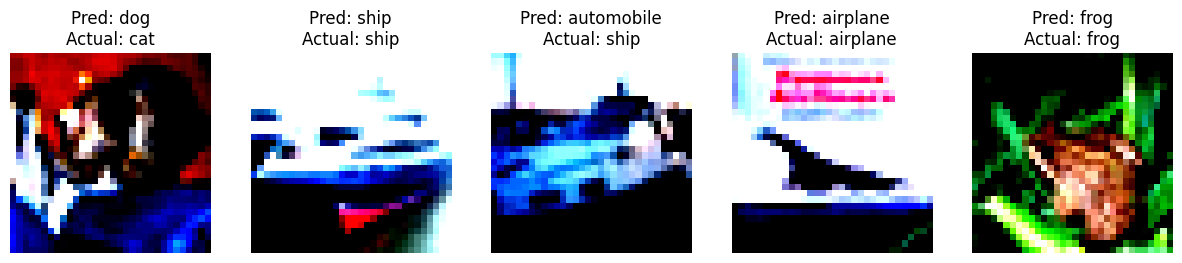

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Define CIFAR-10 class labels
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

# Get a batch of test images
num_samples = 5  # Number of images to predict
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Move images to GPU
images = images.to(device)

# Get model predictions
with torch.no_grad():
    outputs = model(images[:num_samples])
    predicted_classes = torch.argmax(outputs, dim=1)

# Display multiple images with predictions
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
for i in range(num_samples):
    ax = axes[i]
    ax.imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)))  # Convert tensor to image
    ax.set_title(f"Pred: {classes[predicted_classes[i].item()]}\nActual: {classes[labels[i].item()]}")
    ax.axis('off')

plt.show()

In [58]:
print(f"Using device: {device}")
print(f"GPU Available: {torch.cuda.is_available()}")


Using device: cuda
GPU Available: True


In [59]:
import torch
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import random


# Function to unpickle the CIFAR dataset
def unpickle(file):
    with open(file, 'rb') as fo:
        dict_data = pickle.load(fo, encoding='bytes')
    return dict_data

# Path to your unlabeled CIFAR-10 test file
UNLABELED_TEST_PATH = "cifar_test_nolabel.pkl"

# Load test dataset
test_data_dict = unpickle(UNLABELED_TEST_PATH)

# Extract image data and reshape it to match PyTorch expected format (N, 3, 32, 32)
test_images_unlabeled = test_data_dict[b'data']  # Shape: (10000, 32, 32, 3)
test_images_unlabeled = np.transpose(test_images_unlabeled, (0, 3, 1, 2))  # Convert to (N, 3, 32, 32)

# Create a Dataset class for unlabeled test images
class CIFAR10UnlabeledDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = np.transpose(img, (1, 2, 0))  # Convert (3, 32, 32) to (32, 32, 3) for visualization
        
        if self.transform:
            img = self.transform(img)
        return img

# Define transform (same normalization as training)
# test_transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
# ])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # Randomly crop & resize
    transforms.RandomHorizontalFlip(),  # Flip with 50% probability
    transforms.RandomRotation(15),  # Rotate within ±15 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random shift
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Random perspective transformation
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),  # Erase random patches
 
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
]
                                )

# Create DataLoader
unlabeled_test_dataset = CIFAR10UnlabeledDataset(test_images_unlabeled, transform=test_transform)
unlabeled_test_loader = DataLoader(unlabeled_test_dataset, batch_size=128, shuffle=False)

# Predict labels for test images
predictions = []
all_images = []
with torch.no_grad():
    for inputs in unlabeled_test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        predictions.extend(predicted.cpu().numpy())

# Save predictions to CSV
df = pd.DataFrame({"ID": range(len(predictions)), "Labels": predictions})
df.to_csv("submission.csv", index=False)
print("CSV file 'submission.csv' has been generated.")

# Display one image with its predicted label
def show_image(index):
    img = test_images_unlabeled[index]  # Shape (3, 32, 32)
    img = np.transpose(img, (1, 2, 0))  # Convert to (32, 32, 3)
    
    plt.imshow(img.astype(np.uint8))
    plt.axis("off")
    plt.title(f"Predicted Label: {predictions[index],classes[predictions[index]]}")
    plt.show()


# print(len(predictions))
# num_images = min(4, len(predictions))
# indices = random.sample(range(len(predictions)), num_images)  # Select random indices
# print(indices)
# count = 0
# for i in indices:
#     show_image(i)
#     count += 1
#     if count == 5:
         
#         break
# show_image(20)


CSV file 'submission.csv' has been generated.


5


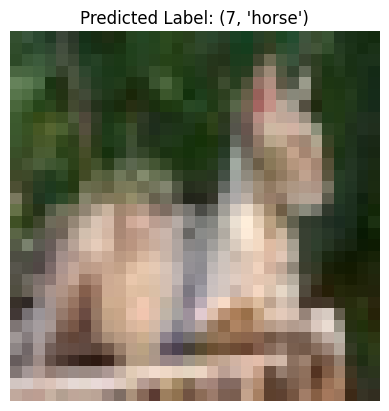

17


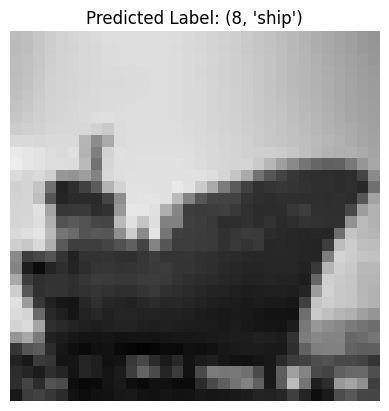

18


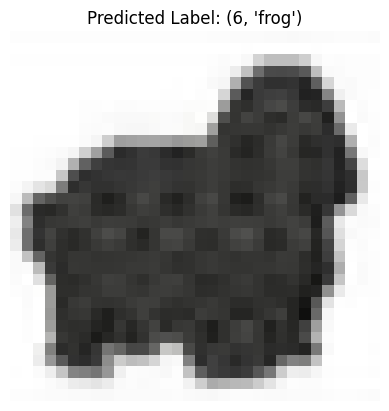

28


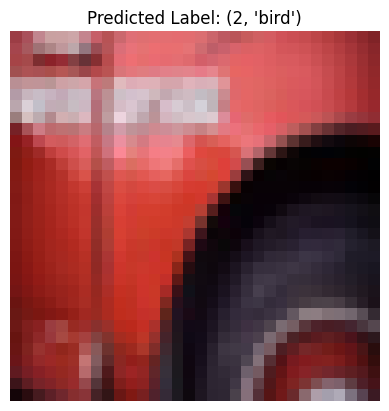

32


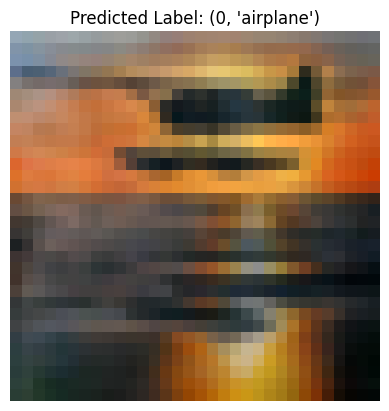

40


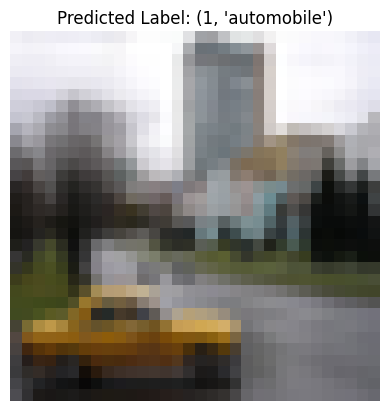

48


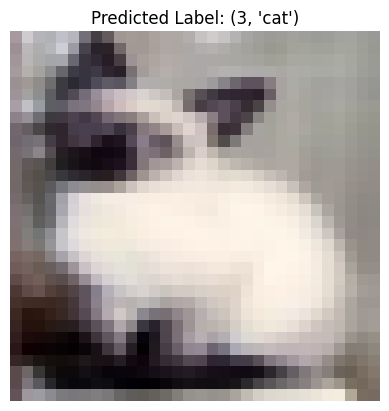

52


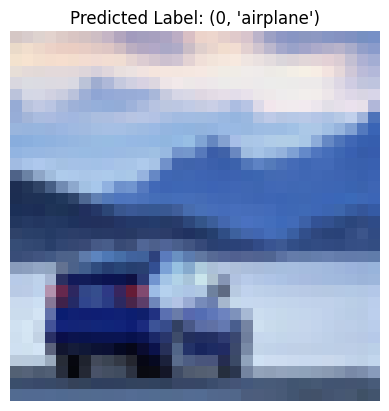

72


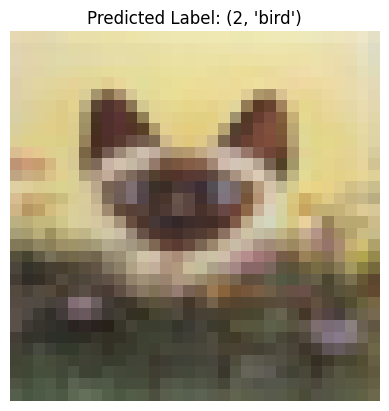

79


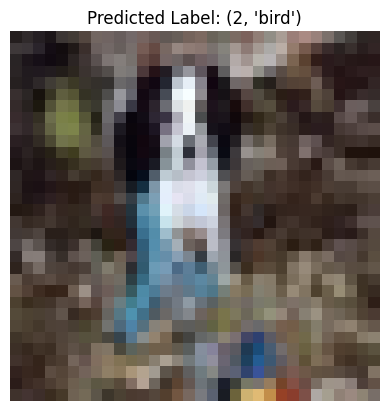

In [60]:
hardimage = [5,17,18,28,32,40,48,52,72,79]
for i in hardimage:
    print(i)
    show_image(i)
 

0


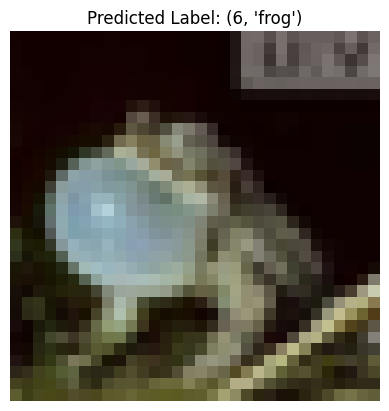

1


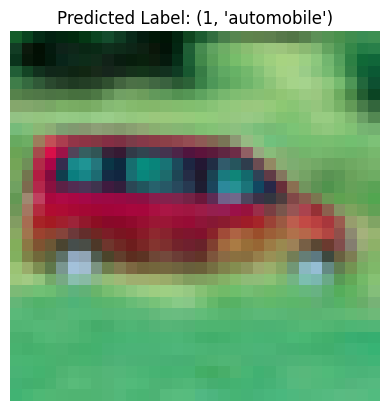

2


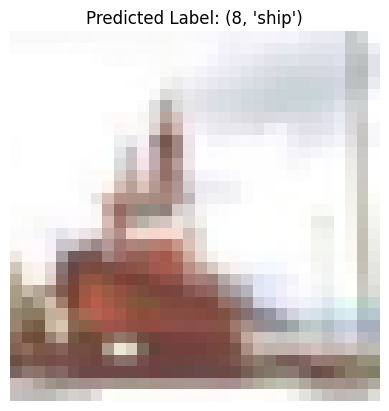

3


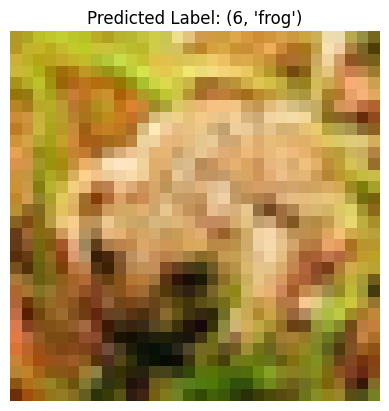

4


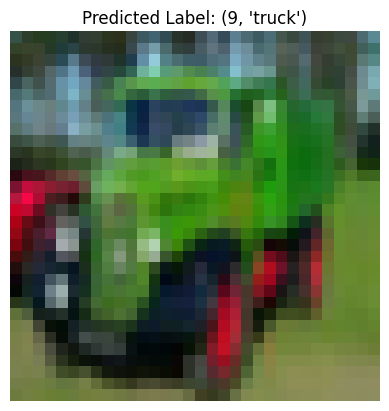

5


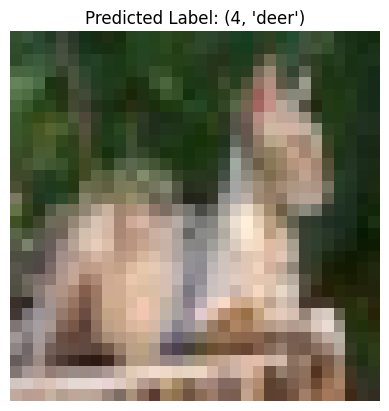

6


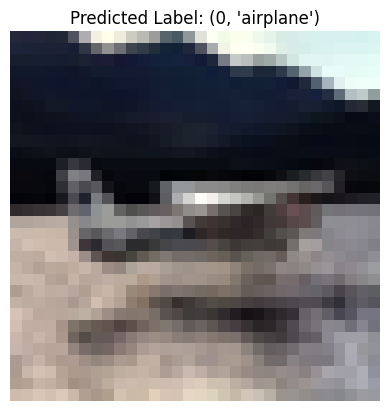

7


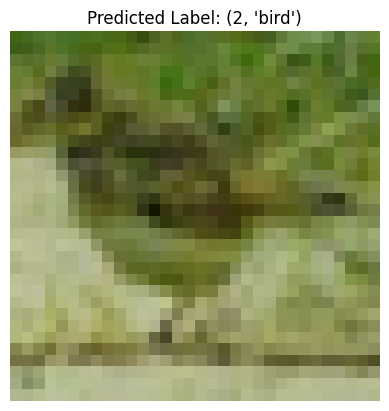

8


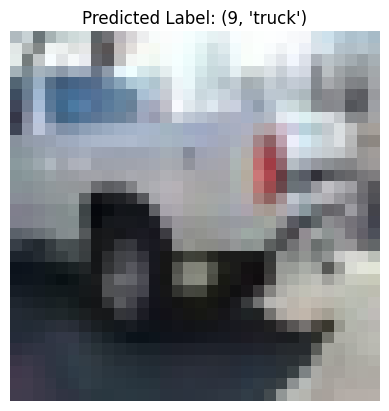

9


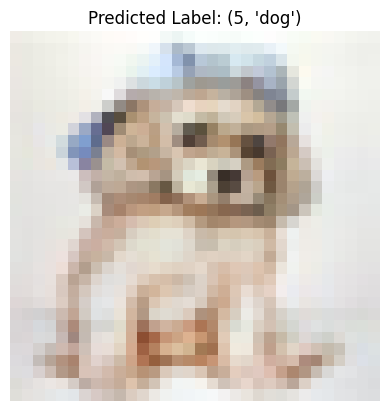

10


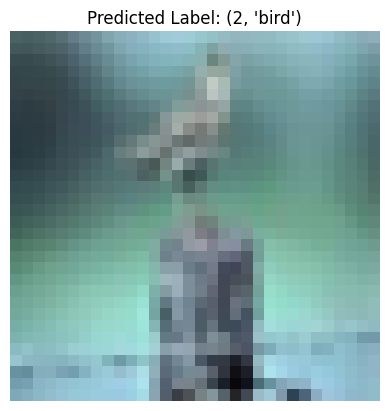

11


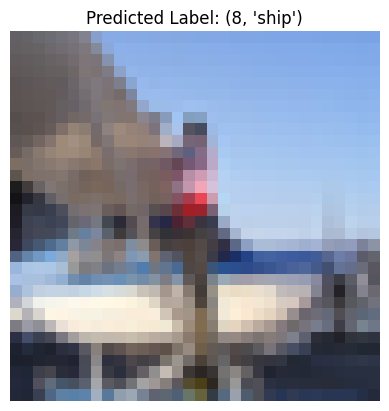

12


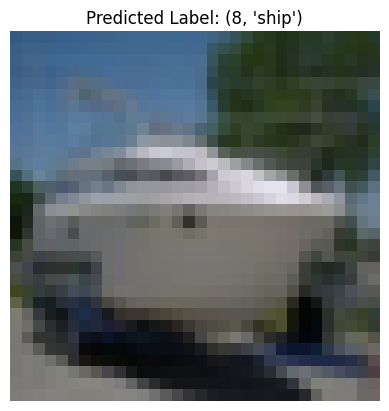

13


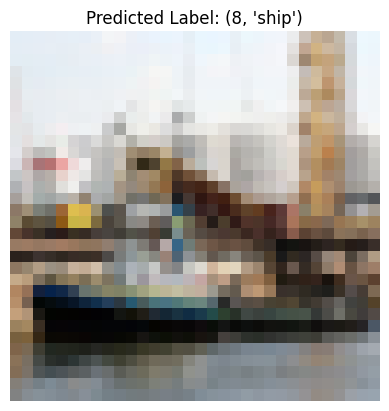

14


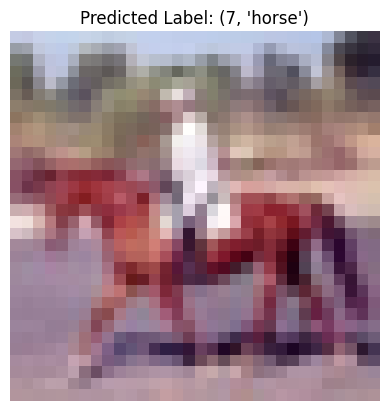

15


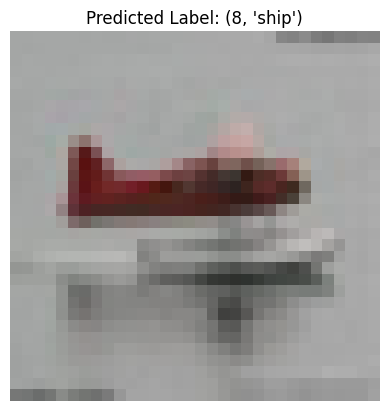

16


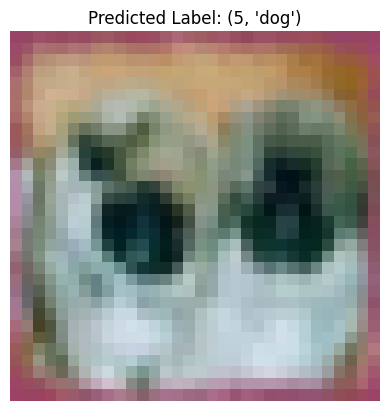

17


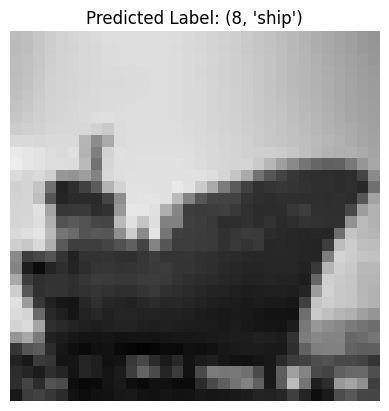

18


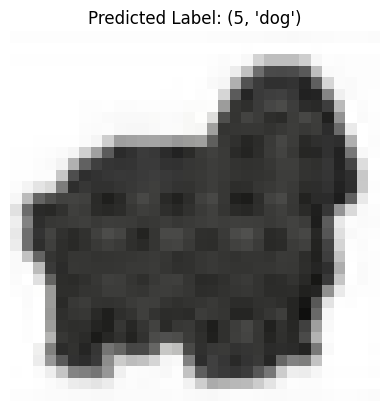

19


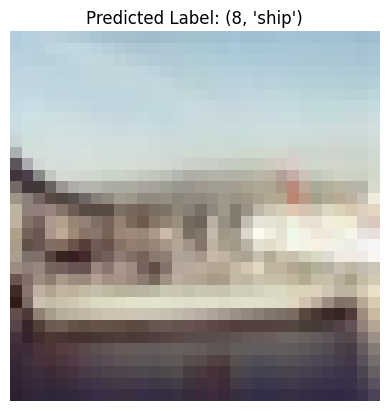

20


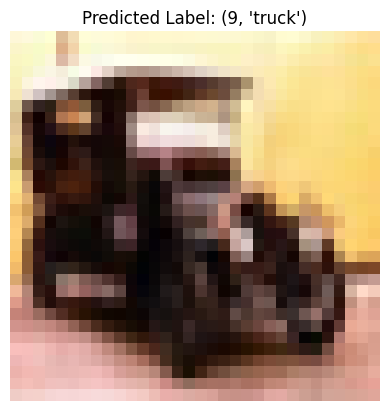

21


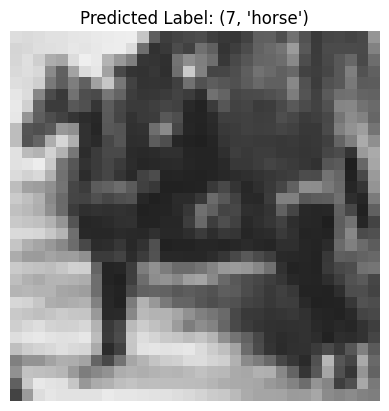

22


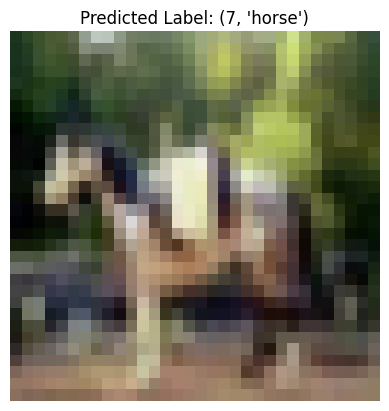

23


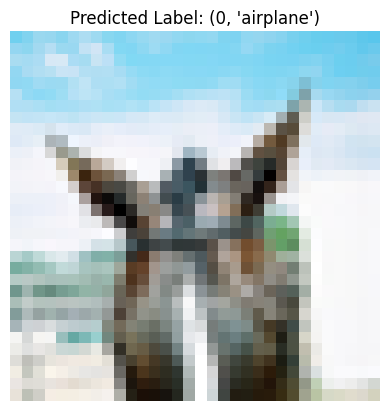

24


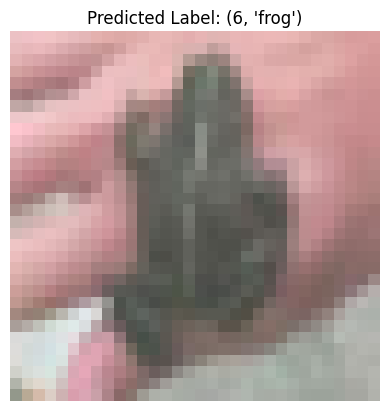

25


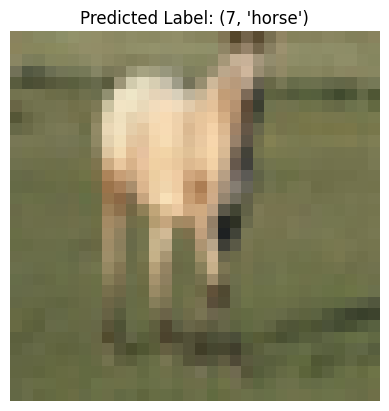

26


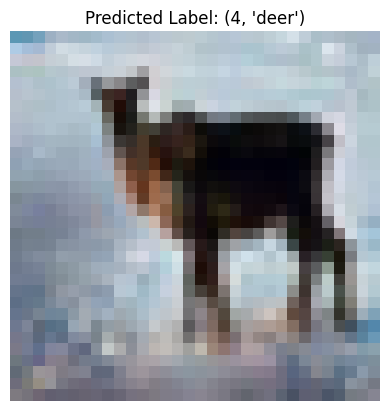

27


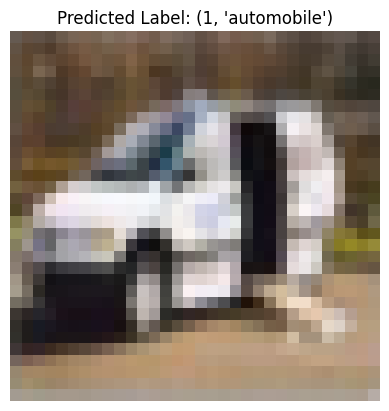

28


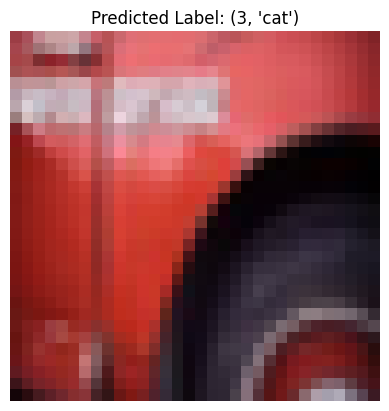

29


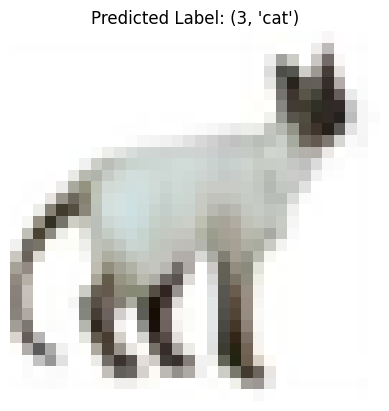

30


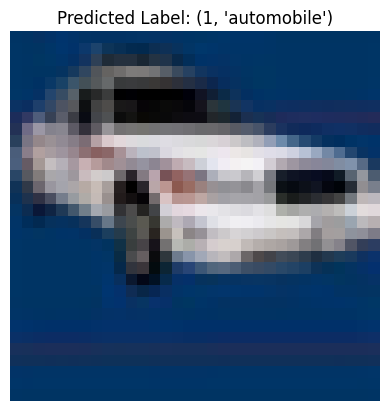

31


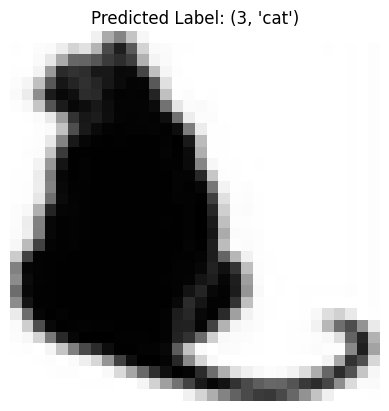

32


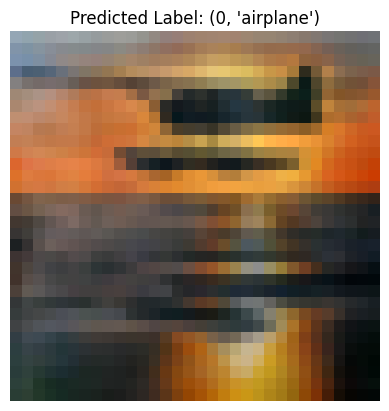

33


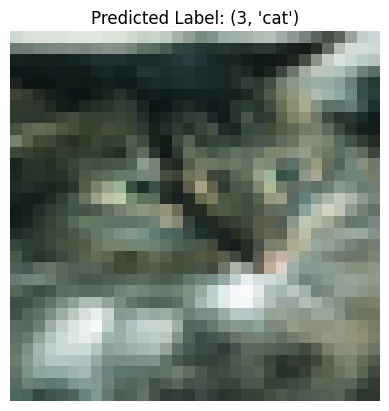

34


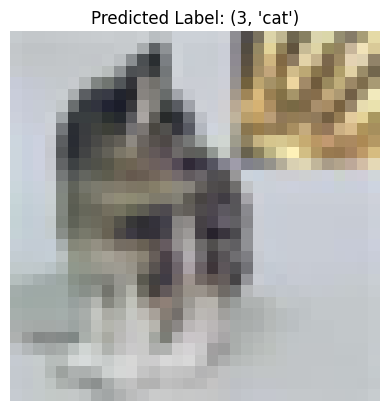

35


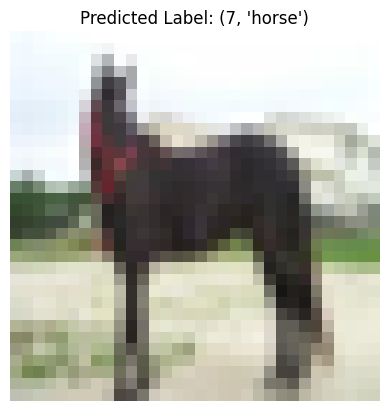

36


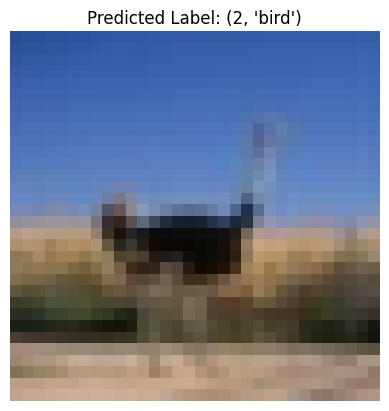

37


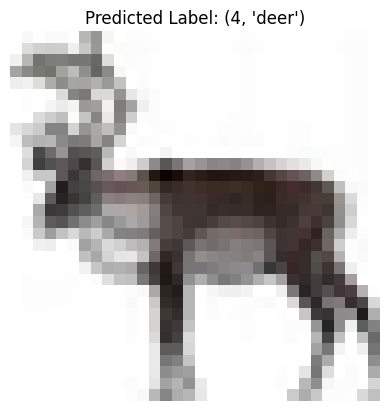

38


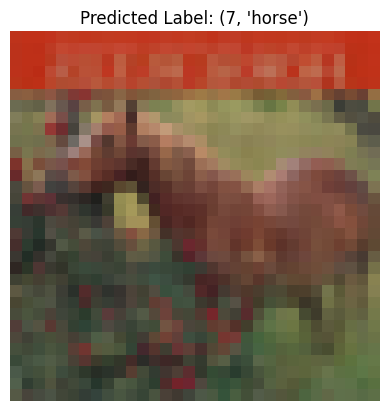

39


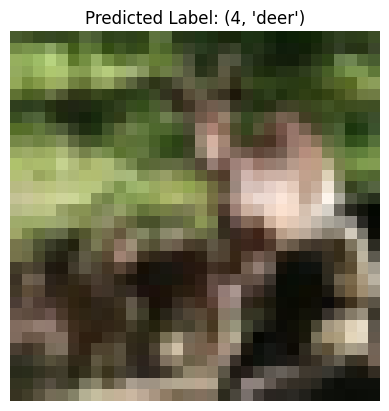

40


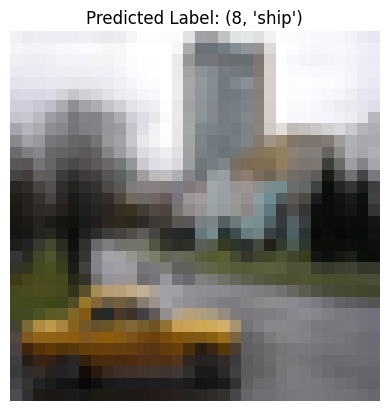

41


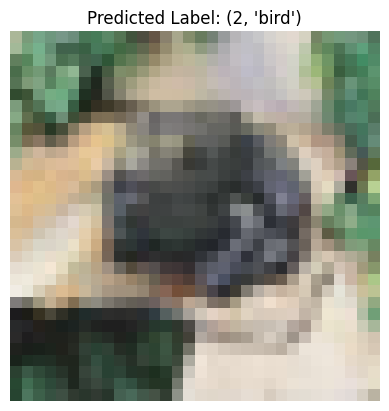

42


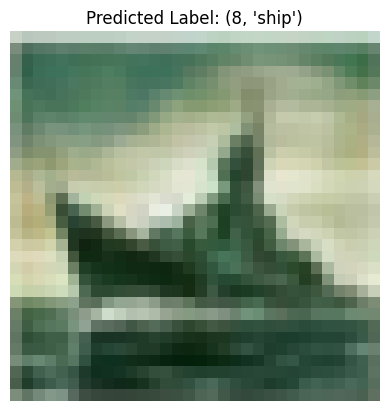

43


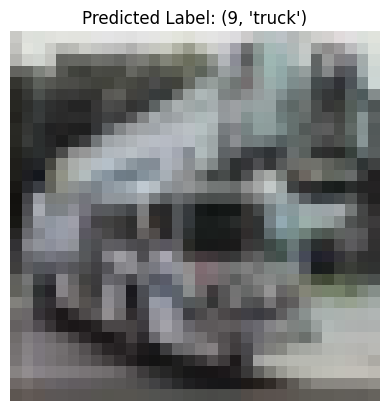

44


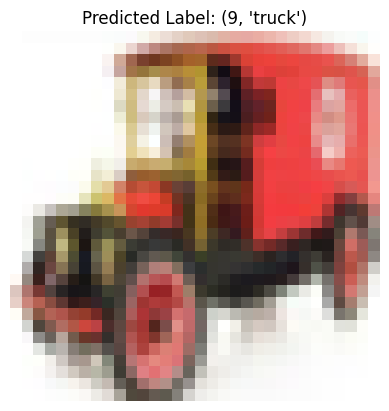

45


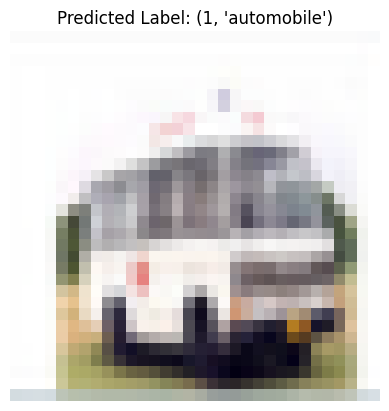

46


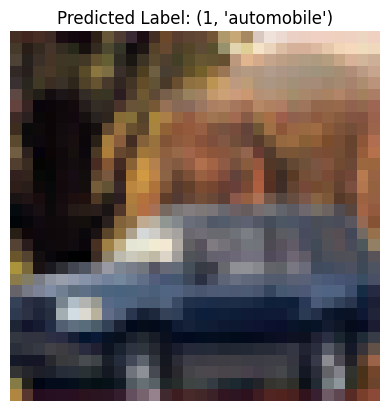

47


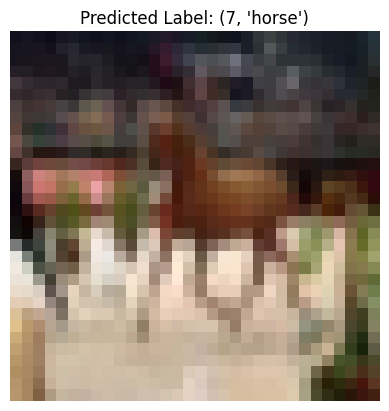

48


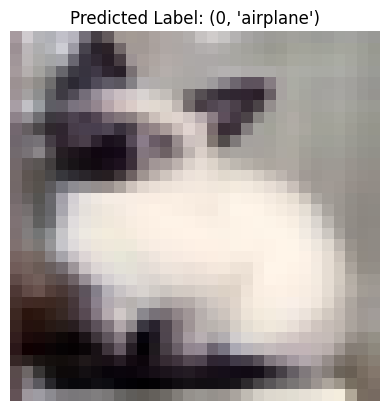

49


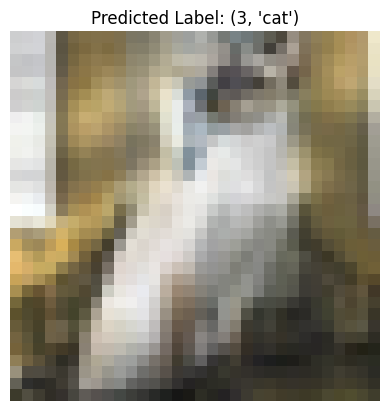

50


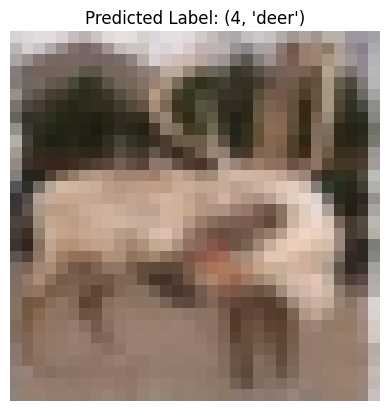

51


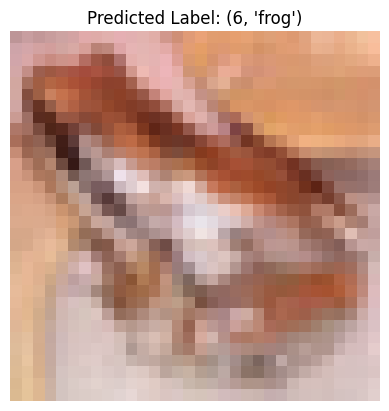

52


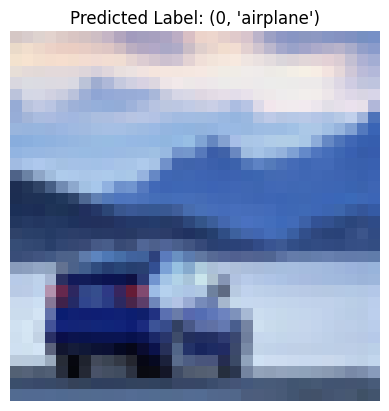

53


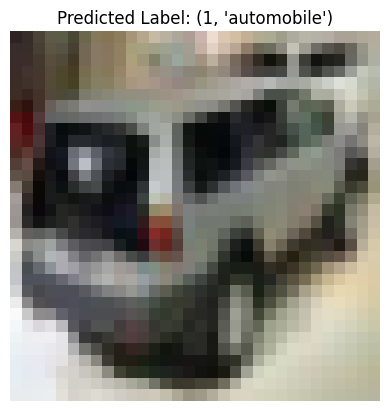

54


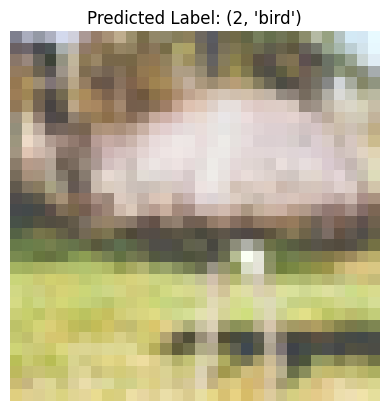

55


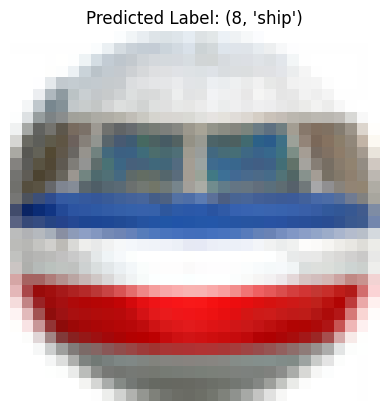

56


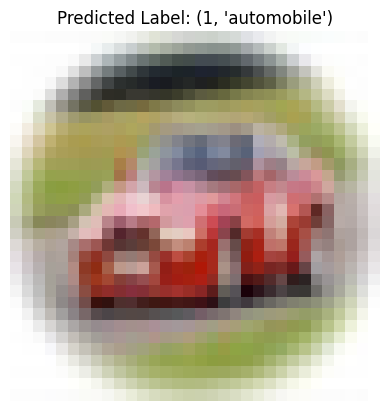

57


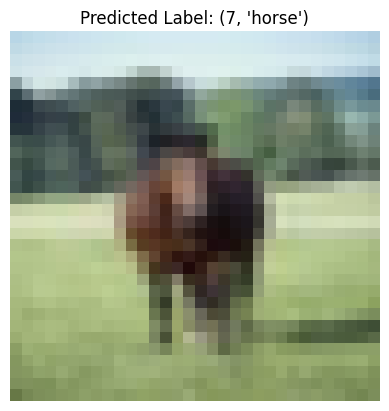

58


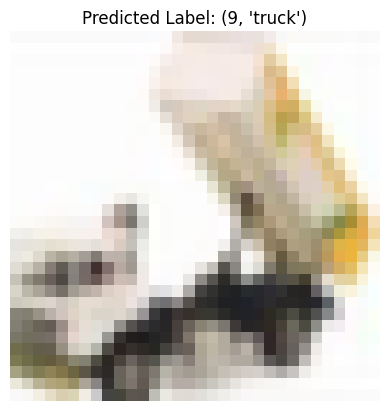

59


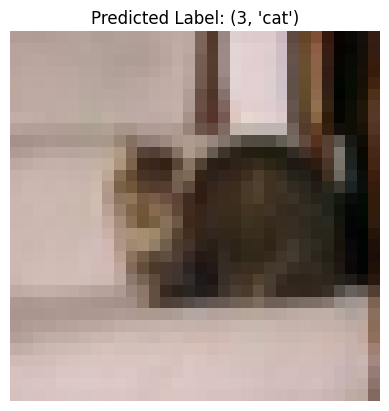

60


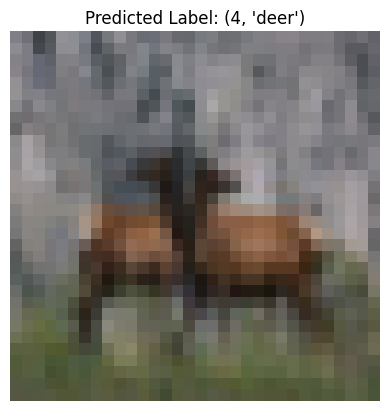

61


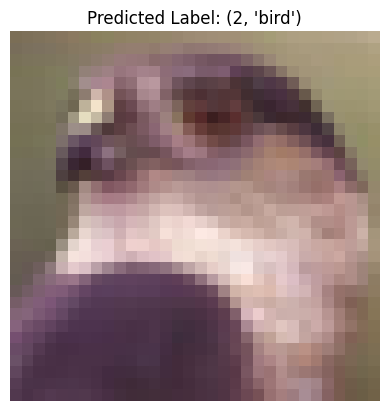

62


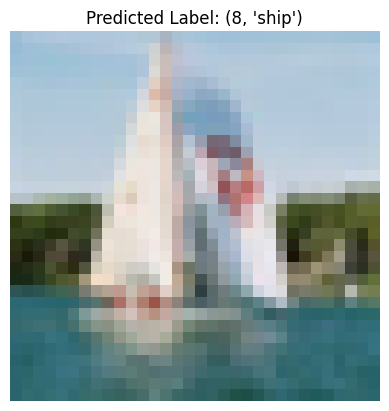

63


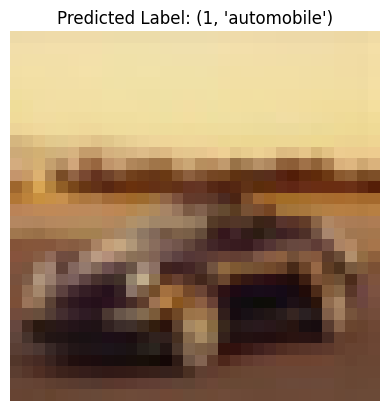

64


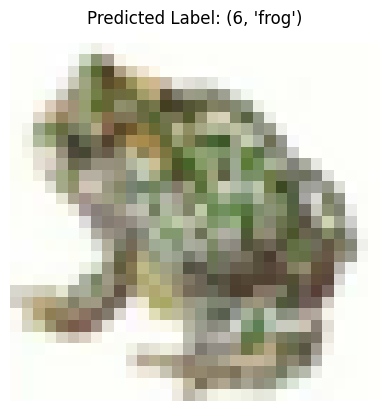

65


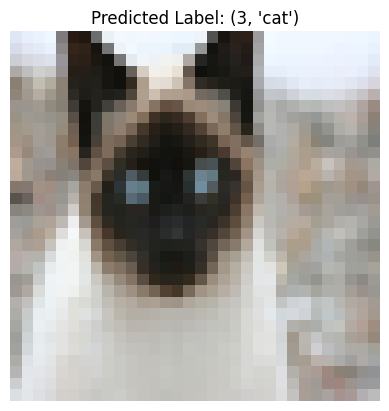

66


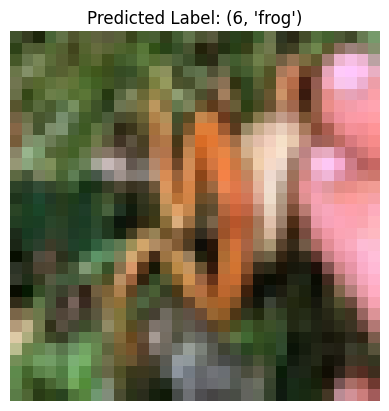

67


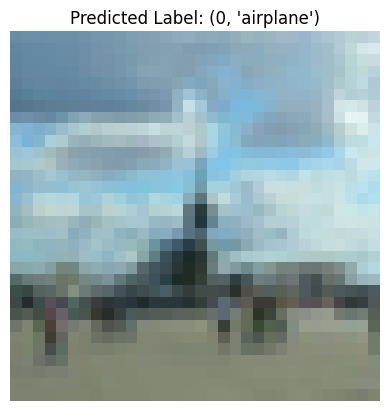

68


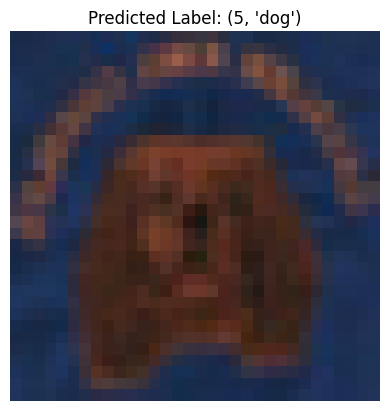

69


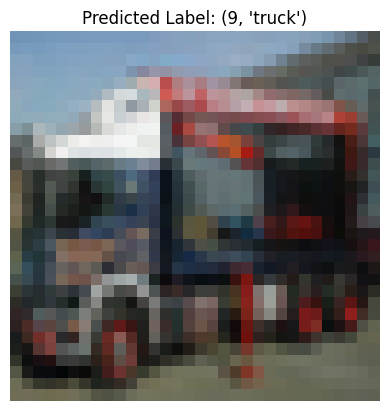

70


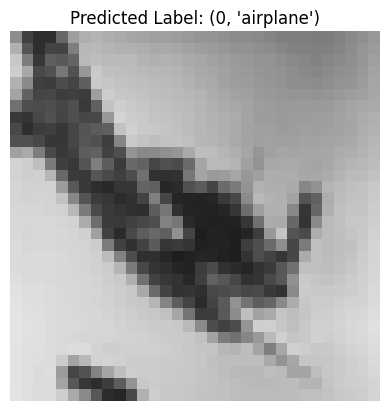

71


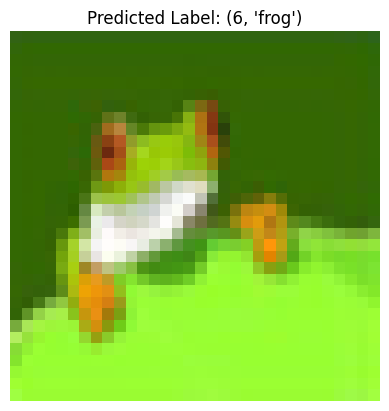

72


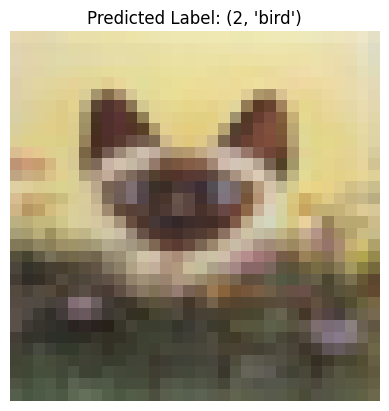

73


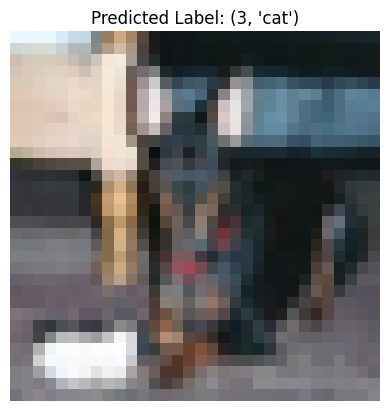

74


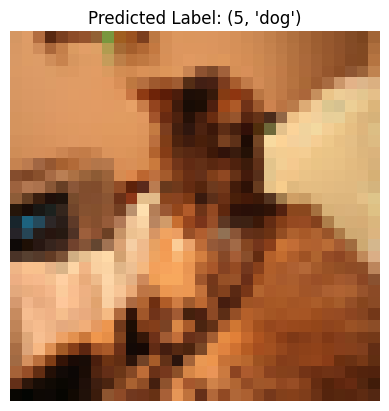

75


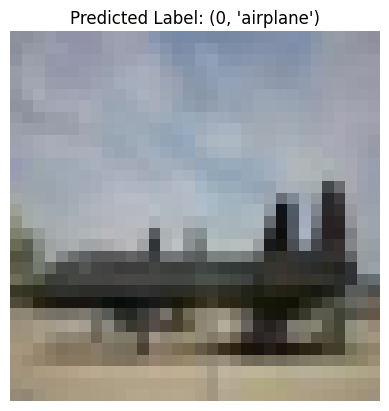

76


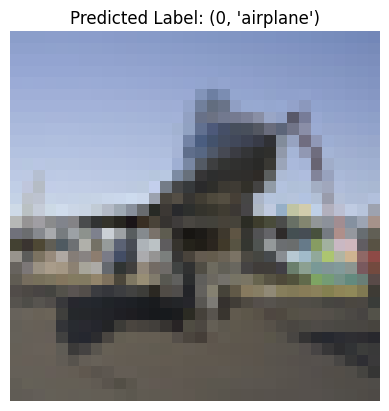

77


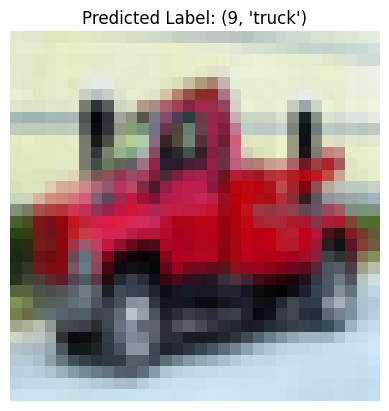

78


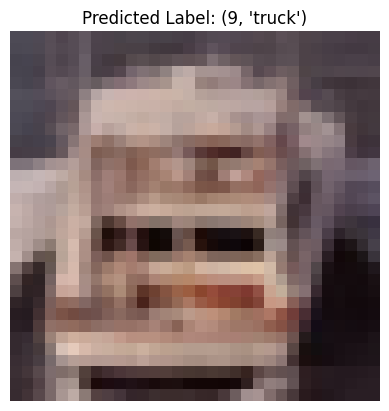

79


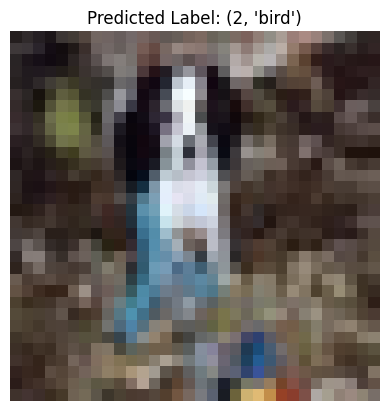

80


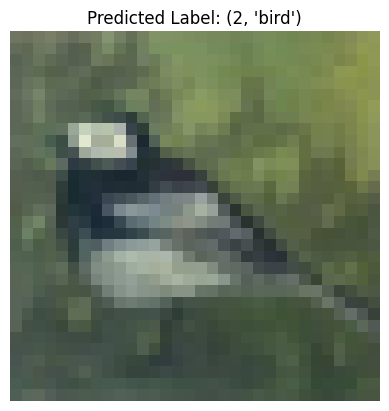

81


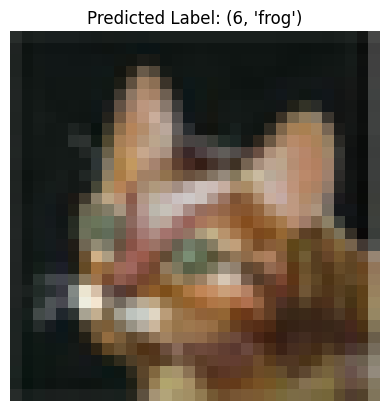

82


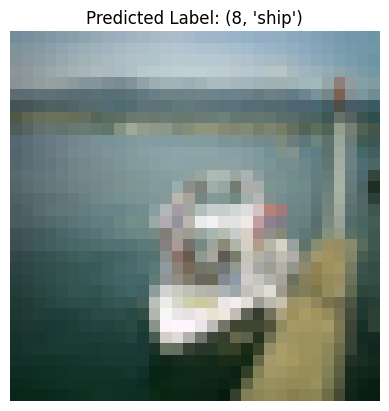

83


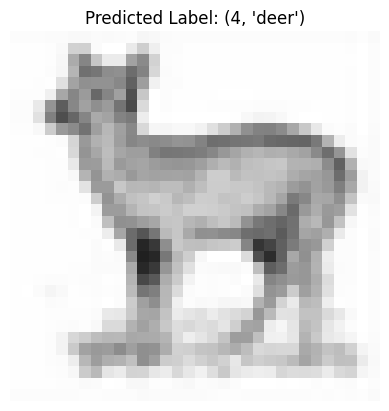

84


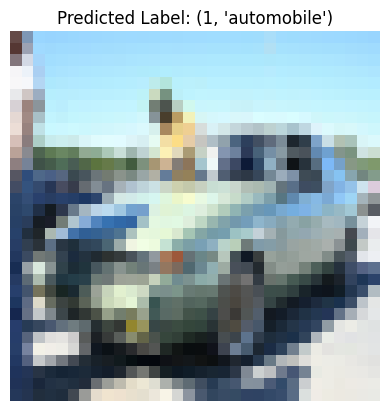

85


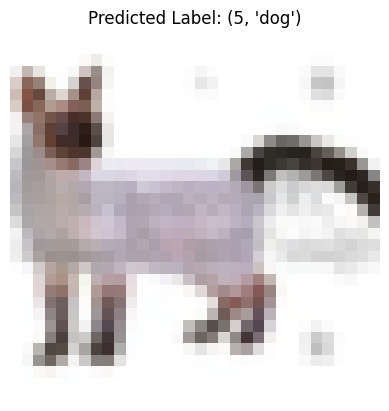

86


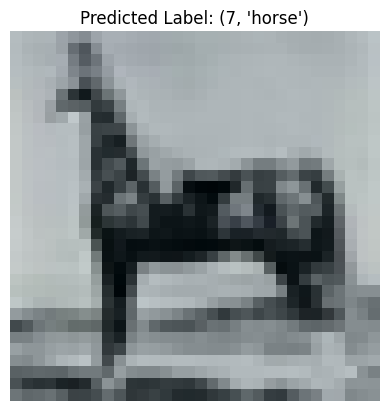

87


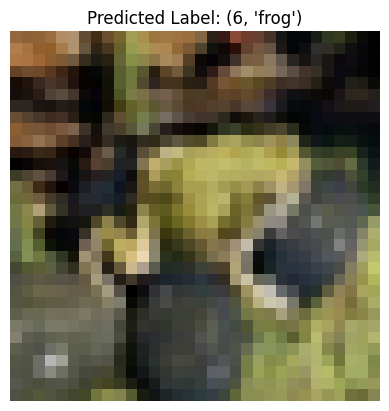

88


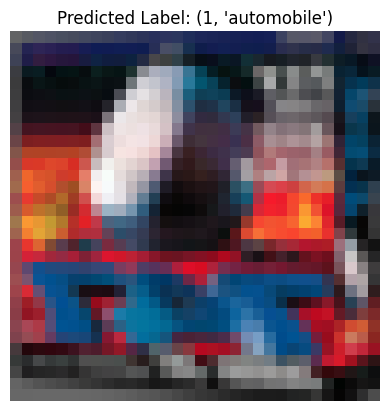

89


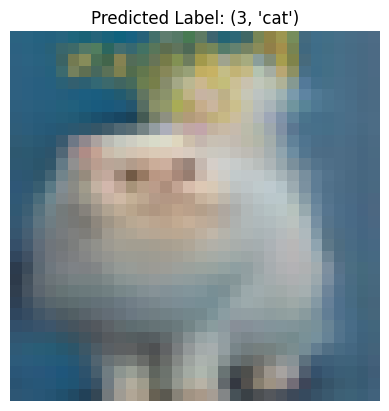

90


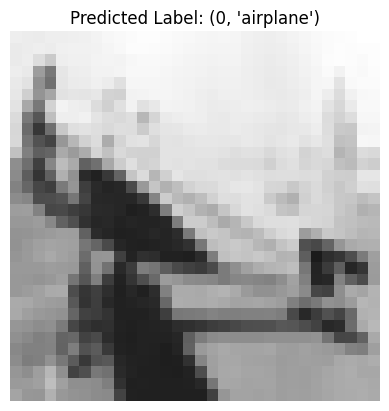

91


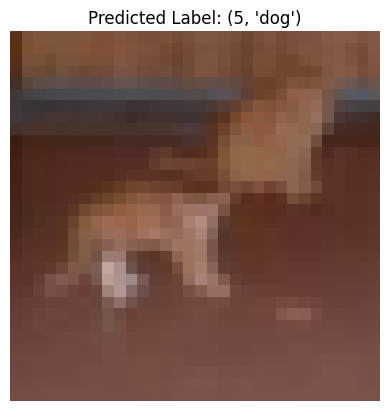

92


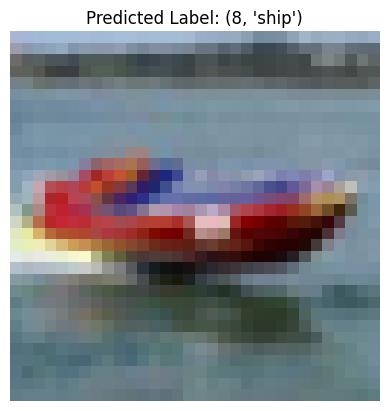

93


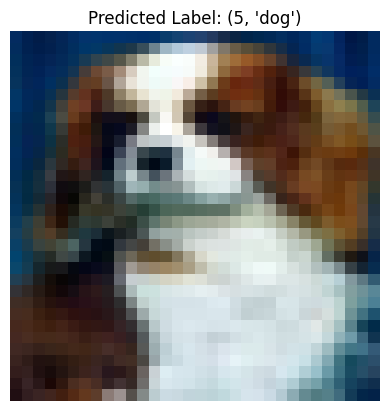

94


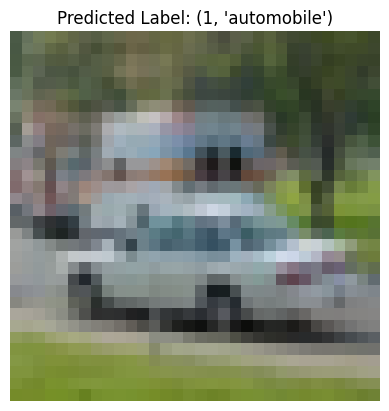

95


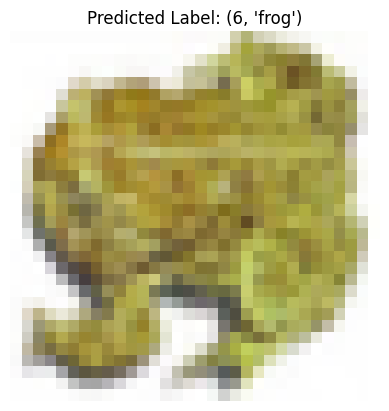

96


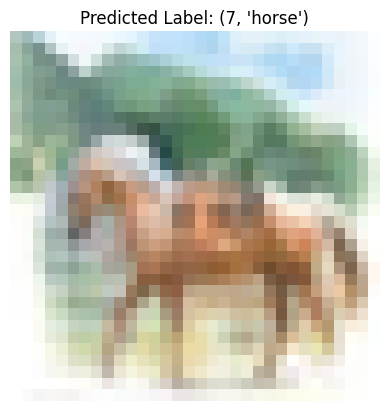

97


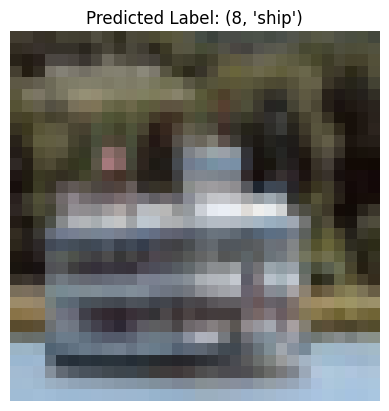

98


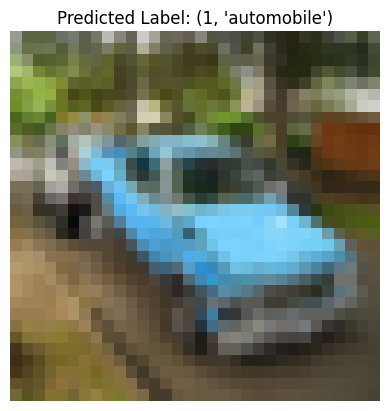

99


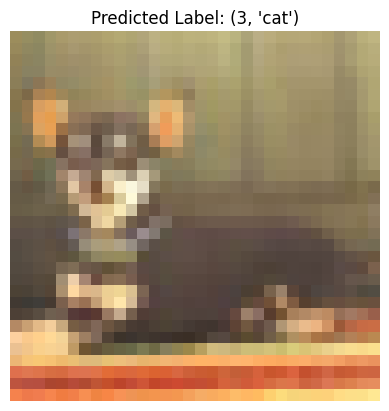

In [54]:
for i in range(100):
    print(i)
    show_image(i)
    

[1826, 3345, 6376, 9728]


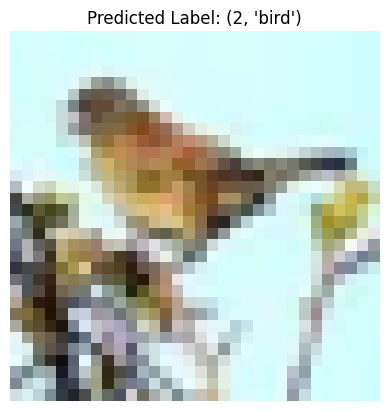

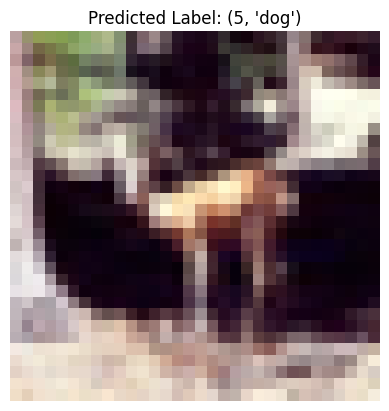

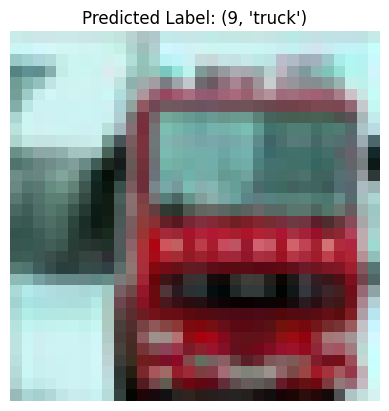

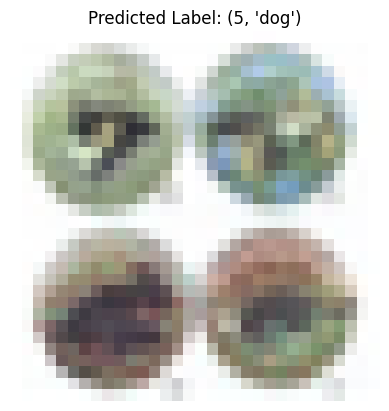

In [30]:
num_images = min(4, len(predictions))
indices = random.sample(range(len(predictions)), num_images)  # Select random indices
print(indices)
count = 0
for i in indices:
    show_image(i)
    count += 1
    if count == 5:
         
        break